In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

# Analisis Exploratorio de Datos

Este documento contiene el analisis exploratorio de datos de los archivos Games, Items y Reviews resultantes del proceso de [ETL](ETL.ipynb) realizado. Adicionalmente, se realizo un [procesamiento de lenguaje natural](#procesamiento-de-lenguaje-natural) para la columna *'review'* del DataFrame **reviews** con el fin de poder hacer el analisis correspondiente a estas nuevas variables.

## Contenido

1. [Carga de datos](#carga-de-datos) <br>
2. [Analisis de Games](#analisis-de-games) <br>
    2.1. [Analisis de BoxPlot 'Price'](#analisis-de-boxplot-price) <br>
    2.2. [Analisis de Correlación](#analisis-de-correlacion-games) <br>
3. [Analisis de Items](#analisis-de-items) <br>
    3.1. [Analisis de BoxPlot 'Playtime'](#analisis-de-boxplot-playtime) <br>
    3.1. [Analisis de Correlación](#analisis-de-correlacion-items) <br>
4. [Analisis de Reviews](#analisis-de-reviews) <br>
    4.1. [Procesamiento de lenguaje natural](#procesamiento-de-lenguaje-natural) <br>
        - [Normalización y tokenización de Oraciones](#normalizacion-y-tokenizacion) <br>
        - [Modelo de Sentiment Analysis](#modelo-de-sentiment-analysis) <br>
        - [Normalización y tokenización de Palabras](#normalizaccion-y-tokenizacion) <br>
    4.2. [Analisis de Correlación](#analisis-de-correlacion-reviews) <br>
5. [Exportar archivos](#exportar-archivos) <br>

## Carga de datos

In [4]:
games=pd.read_parquet("Archivos ETL/games_etl.parquet")

In [8]:
items=pd.read_parquet("Archivos ETL/items_etl.parquet")

In [9]:
reviews=pd.read_parquet("Archivos ETL/reviews_etl.parquet")

## Analisis de Games

En esta seccion se encuentra todo el analisis de las columnas del DataFrame **Games**. Tenemos inicialmente 120.445 registros y 9 columnas con 3 tipos de datos: listas (genres, tags y specs), float (price, early_access, item_id y release_year) y string (item_name y developer). No se realizó analisis de la columna **'item_id'** ya que es el identificador unico del juego, no presenta repetidos ni tendencias.

In [7]:
games

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
0,None,None,None,None,NaN,NaN,NaN,None,NaN
1,None,None,None,None,NaN,NaN,NaN,None,NaN
2,None,None,None,None,NaN,NaN,NaN,None,NaN
3,None,None,None,None,NaN,NaN,NaN,None,NaN
4,None,None,None,None,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0
120442,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0
120443,"[Casual, Indie]",EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns",2017.0


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28852 non-null  object 
 1   item_name     32133 non-null  object 
 2   tags          31972 non-null  object 
 3   specs         31465 non-null  object 
 4   price         30758 non-null  float64
 5   early_access  32135 non-null  float64
 6   item_id       32133 non-null  float64
 7   developer     28836 non-null  object 
 8   release_year  29964 non-null  float64
dtypes: float64(4), object(5)
memory usage: 8.3+ MB


### Manejo de nulos y vacios

Se tienen un total de 805.757 nulos a traves de todas las columnas. De estos, se tienen 88.310 registros donde todos los valores son nulos. De acuerdo con esto, se decidio eliminar estos registros.

In [7]:
games.head()

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
0,None,None,None,None,NaN,NaN,NaN,None,NaN
1,None,None,None,None,NaN,NaN,NaN,None,NaN
2,None,None,None,None,NaN,NaN,NaN,None,NaN
3,None,None,None,None,NaN,NaN,NaN,None,NaN
4,None,None,None,None,NaN,NaN,NaN,None,NaN


In [6]:
games.isnull().sum()

genres          91593
item_name       88312
tags            88473
specs           88980
price           89687
early_access    88310
item_id         88312
developer       91609
release_year    90481
dtype: int64

In [11]:
games.dropna(how='all',inplace=True)

In [12]:
games

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,2017.0
88313,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0.0,767400.0,彼岸领域,2017.0
88314,None,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,NaN
...,...,...,...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0
120442,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0
120443,"[Casual, Indie]",EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns",2017.0


Se revisaron los valores nulos de las columnas 'app_name' y 'item_id' ya que se consideraron las mas importantes. Se busco los id y nombres en el DataFrame items para completar la informacion, pero al no encontraste en este DataFrame se decidio borrar los registros. Se borraron 3 registros.

In [13]:
games[(games['item_name'].isnull())|(games['item_id'].isnull())]
#items[items['item_id']==317160.0]
#items[items['item_name']=='Batman: Arkham City - Game of the Year Edition']

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
88384,None,None,None,None,19.99,0.0,NaN,None,NaN
90890,"[Action, Indie]",None,"[Action, Indie]","[Single-player, Game demo]",NaN,0.0,317160.0,None,2014.0
119271,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)",2012.0


In [12]:
#Borra registro sin app_name y item_id
games.drop(games[(games['item_name'].isnull())|(games['item_id'].isnull())].index,inplace=True)

### Manejo de duplicados

Se realizó una revisión de los duplicados en el DataFrame y se encontró 1 que se tomó la decisión de borrar.

In [13]:
games.drop(games[games.duplicated(subset=['item_name', 'release_year', 'price', 'early_access', 'item_id',
       'developer'])].index,inplace=True)

Se creó una función que permitiera extraer todos los valores unicos en las listas de ´genres', 'tags' y 'specs' para realizaron un correcto analisis de estas variables.

In [25]:
#Crea una lista con todos los unicos de las listas de una columna
def frec_unicos(col):
    u = []
    for sublist in col:
        if type(sublist)==np.ndarray or type(sublist)==list:
            for genre in sublist:
                u.append(genre)
    return pd.Series(u).value_counts()

### Genres

La columna **'genres'** contiene los nombres de los generos a los que pertenece cada jueco. Para esta se tiene un total de 3.283 valores nulos. Esta columna contiene listas de diferentes tamaños compuestas por 22 tipos diferentes de generos. Se tiene que los 5 generos que mas se encuentran en los items analizados son *Indie* en 15.857 registros (49.35% de los registros), *Action* en 11.318 (35.22%), *Casual* en 8.282 (25.77%), *Adventure* en 8.242 (25.65%) y *Strategy* en 6.957 (21.65%). 

In [14]:
games['genres'].isnull().sum()

np.int64(3282)

In [15]:
games['genres']

88310         [Action, Casual, Indie, Simulation, Strategy]
88311                  [Free to Play, Indie, RPG, Strategy]
88312     [Casual, Free to Play, Indie, Simulation, Sports]
88313                           [Action, Adventure, Casual]
88314                                                  None
                                ...                        
120440                [Casual, Indie, Simulation, Strategy]
120441                            [Casual, Indie, Strategy]
120442                          [Indie, Racing, Simulation]
120443                                      [Casual, Indie]
120444                                                 None
Name: genres, Length: 32131, dtype: object

In [18]:
lista_genres=frec_unicos(games['genres'])

In [19]:
lista_genres

Indie                        15857
Action                       11318
Casual                        8282
Adventure                     8242
Strategy                      6957
Simulation                    6699
RPG                           5479
Free to Play                  2031
Early Access                  1462
Sports                        1257
Massively Multiplayer         1108
Racing                        1083
Design &amp; Illustration      460
Utilities                      340
Web Publishing                 268
Animation &amp; Modeling       183
Education                      125
Video Production               116
Software Training              105
Audio Production                93
Photo Editing                   77
Accounting                       7
Name: count, dtype: int64

In [20]:
lista_genres.size

22

A continuacion se pueden observar la distribucion de los generos en este conjunto de datos.

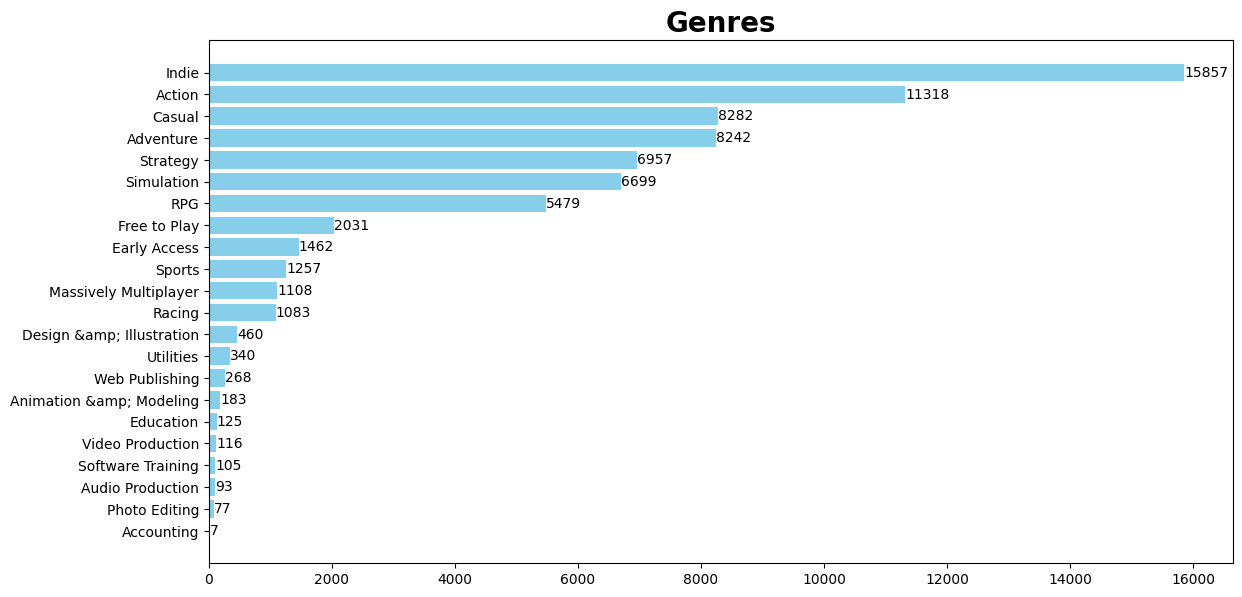

In [21]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(lista_genres.index,lista_genres.values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Genres', fontweight = 'bold',fontsize=20)
for index, value in enumerate(lista_genres.values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Item_name

La variable **'item_name'** representa los nombres de los juegos que se encuentran en la plataforma. Esta columna contiene valores nulos a parte de los 88.312 registros completamente nulos que se mencionaron anteriormente y se tienen 32.094 nombres diferentes. Se tiene 1 nombre que se encuentra 3 veces, 35 que se repiten 2 veces y los demas se encuentran una unica vez. Se decidio no borrar estos duplicados ya que pertenecian a diferentes *'item_id'* y gran parte de ellos contenia informacion diferente para los demas atributos del item.

In [16]:
games['item_name'].isnull().sum()

np.int64(0)

In [22]:
np.size(games['item_name'].unique())

32094

In [21]:
games['item_name'].value_counts().head(37)

item_name
Soundtrack                                        3
Escape Room                                       2
Taxi                                              2
WARZONE                                           2
Total Extreme Wrestling                           2
Colony                                            2
Dark Matter                                       2
Invasion                                          2
Alter Ego                                         2
Castles                                           2
Archangel                                         2
Hero                                              2
New York Bus Simulator                            2
Invisible Apartment Zero                          2
Invisible Apartment 2                             2
Rumpus                                            2
Luna                                              2
The Fog                                           2
MORE SWEATER? OK!                                 2
Go

In [24]:
games[games.duplicated(subset=['item_name'],keep=False)].sort_values('item_name')

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
107158,None,AirMech® Soundtrack,"[Strategy, Action, Indie]","[Single-player, Multi-player, Online Multi-Pla...",9.99,0.0,599520.0,None,NaN
118857,"[Action, Free to Play, Indie, Strategy]",AirMech® Soundtrack,"[Strategy, Action, Free to Play, Indie]","[Single-player, Multi-player, Co-op, Downloada...",9.99,0.0,216173.0,Carbon Games,2012.0
118489,[Action],Aliens: Colonial Marines - Reconnaissance Pack,[Action],"[Single-player, Multi-player, Co-op, Downloada...",29.99,0.0,219441.0,Gearbox Software,2013.0
118488,[Action],Aliens: Colonial Marines - Reconnaissance Pack,[Action],"[Single-player, Multi-player, Co-op, Downloada...",NaN,0.0,224850.0,Gearbox Software,2013.0
119713,[Adventure],Alter Ego,"[Adventure, Point & Click, Mystery, Detective]",[Single-player],9.99,0.0,63110.0,bitComposer Games,2010.0
...,...,...,...,...,...,...,...,...,...
110009,"[Action, Indie]",Ultimate Arena,"[Action, Indie, Arena Shooter, FPS, Multiplaye...","[Multi-player, Online Multi-Player, Steam Achi...",11.15,0.0,436260.0,"Kenneth Caselli,Gianmarco Rocco",2016.0
94892,"[Action, Indie]",WARZONE,"[Action, Indie, Singleplayer, FPS, First-Perso...","[Single-player, Multi-player, Online Multi-Pla...",2.99,0.0,494290.0,"NFA,Claw Games",2016.0
100232,"[Indie, Massively Multiplayer, Strategy]",WARZONE,"[Indie, Strategy, Massively Multiplayer]","[Single-player, Multi-player, Online Multi-Pla...",9.99,0.0,712230.0,KEA Games,2017.0
115981,"[RPG, Strategy]",Warhammer Quest,"[Strategy, RPG]","[Single-player, Downloadable Content, Steam Ac...",NaN,0.0,329270.0,"Twistplay,Rodeo Games",2015.0


### Tags

La columna **'tags'** contiene etiquetas que representan a cada juego. Estas contienen valores de la columna *'genres'*y valores adicionales. En total se tienen 339 tags diferentes. Se tiene que los 5 tags que mas se presentan en los items analizados son *Indie* en 17.619 registros (54.83% de los registros), *Action* en 13.002 (40.46%), *Adventure* en 9.829 (30.59%), *Casual* en 9.739 (30.31%) y *Simulation* en 7.730 (24.08%).

In [34]:
games['tags']

88310         [Strategy, Action, Indie, Casual, Simulation]
88311     [Free to Play, Strategy, Indie, RPG, Card Game...
88312     [Free to Play, Simulation, Sports, Casual, Ind...
88313                           [Action, Adventure, Casual]
88314                       [Action, Indie, Casual, Sports]
                                ...                        
120440                [Strategy, Indie, Casual, Simulation]
120441                            [Strategy, Indie, Casual]
120442                          [Indie, Simulation, Racing]
120443    [Indie, Casual, Puzzle, Singleplayer, Atmosphe...
120444    [Early Access, Adventure, Indie, Action, Simul...
Name: tags, Length: 32131, dtype: object

In [26]:
lista_tags=frec_unicos(games['tags'])

In [28]:
pd.set_option('display.max_rows', None)
print(lista_tags)
pd.reset_option('display.max_rows')

Indie                                17619
Action                               13002
Adventure                             9829
Casual                                9739
Simulation                            7730
Strategy                              7566
RPG                                   5919
Singleplayer                          4344
Free to Play                          2406
Multiplayer                           2383
Great Soundtrack                      2234
Puzzle                                2111
Early Access                          1947
2D                                    1945
Atmospheric                           1933
VR                                    1796
Sports                                1597
Platformer                            1449
Story Rich                            1444
Sci-fi                                1387
Fantasy                               1363
Horror                                1332
Open World                            1317
Difficult  

In [27]:
lista_tags.size

339

A continuacion se pueden observar las 15 etiquetas que mas se presentan en este conjunto de datos.

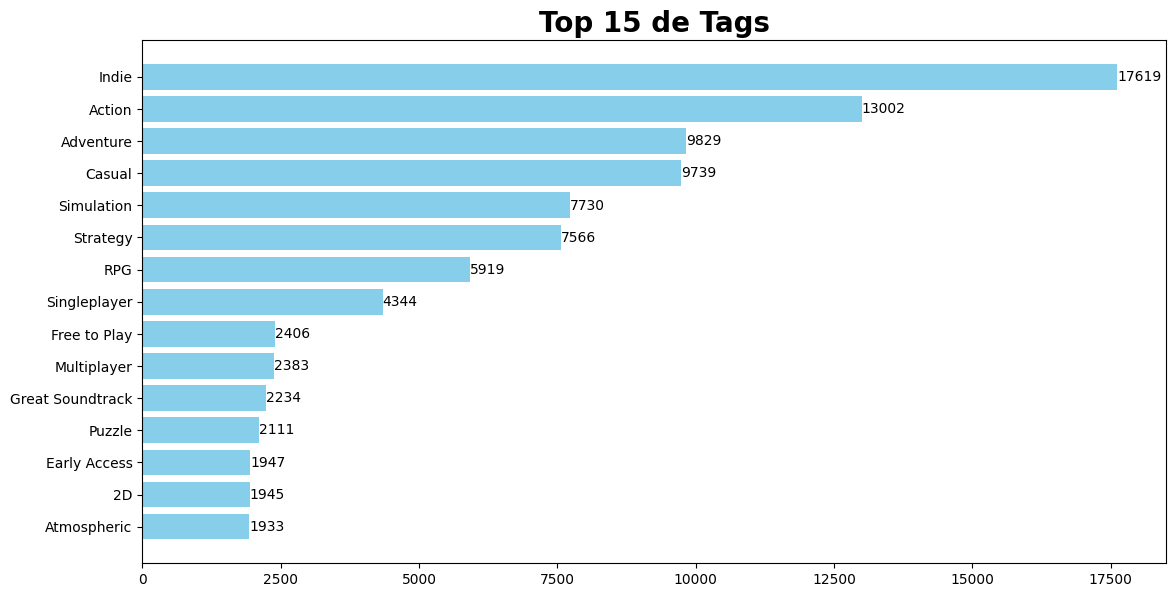

In [28]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(lista_tags.head(15).index,lista_tags.head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 de Tags', fontweight = 'bold',fontsize=20)
for index, value in enumerate(lista_tags.head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Specs

La columna **'specs'** contiene las listas con las especificaciones de los juegos, tiene 669 valores nulos. En total son 40 especificaciones diferentes. Las principales son *Single-player* con 27.574 registros (en el 85.82% de los registros), *Steam Achievements* con 16.364 (50.93%), *Downloadable Content* con 12.691 (39.50%), *Steam Trading Cards* con 12.198 (37.96%) y *Steam Cloud* con 9.958 (30.99%)

In [36]:
games['specs'].isnull().sum()

np.int64(669)

In [35]:
games['specs']

88310                                       [Single-player]
88311     [Single-player, Multi-player, Online Multi-Pla...
88312     [Single-player, Multi-player, Online Multi-Pla...
88313                                       [Single-player]
88314     [Single-player, Full controller support, HTC V...
                                ...                        
120440                  [Single-player, Steam Achievements]
120441    [Single-player, Steam Achievements, Steam Clou...
120442    [Single-player, Steam Achievements, Steam Trad...
120443     [Single-player, Steam Achievements, Steam Cloud]
120444    [Single-player, Stats, Steam Leaderboards, HTC...
Name: specs, Length: 32131, dtype: object

In [29]:
lista_specs=frec_unicos(games['specs'])

In [30]:
lista_specs

Single-player                 27574
Steam Achievements            16364
Downloadable Content          12691
Steam Trading Cards           12198
Steam Cloud                    9958
Multi-player                   8198
Full controller support        7384
Partial Controller Support     6538
Steam Leaderboards             6081
Co-op                          4280
Shared/Split Screen            3962
Cross-Platform Multiplayer     2550
Online Multi-Player            2370
Stats                          2321
HTC Vive                       1984
Steam Workshop                 1866
Tracked Motion Controllers     1816
Captions available             1643
Standing                       1462
Room-Scale                     1445
Includes level editor          1377
Local Multi-Player             1237
Oculus Rift                    1213
Seated                         1090
Online Co-op                    998
MMO                             942
In-App Purchases                933
Local Co-op                 

In [31]:
lista_specs.size

40

A continuacion se pueden observar las 15 especificaciones que mas se presentan en este conjunto de datos.

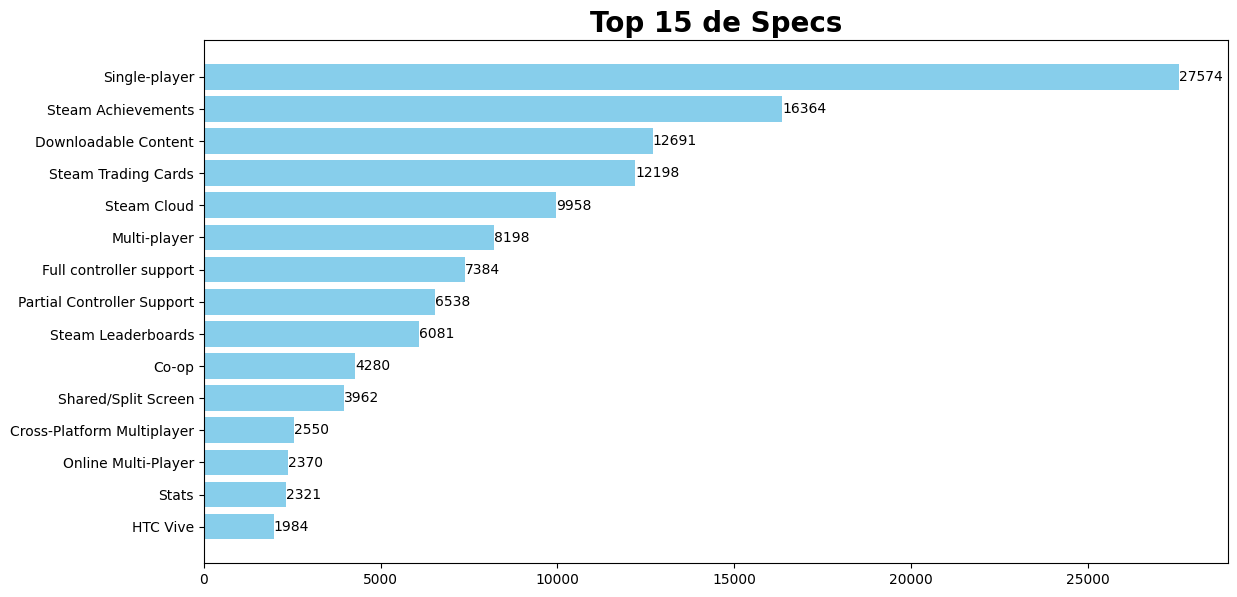

In [32]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(lista_specs.head(15).index,lista_specs.head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 de Specs', fontweight = 'bold',fontsize=20)
for index, value in enumerate(lista_specs.head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Price

La columna **'price'** corresponde al precio de venta del juego. Se tienen 1.376 nulos y 1.908 en $0 (juegos gratuitos). En promedio los juegos valen alrededor de $8.89. Sin embargo, se considera que este valor no es representativo debido a la cantidad de valores en $0 y precios muy elevados (tenemos un precio maximo de $995, mas de 100 veces el promedio).

In [42]:
games['price'].isnull().sum()

np.int64(1376)

In [33]:
games['price'].describe()

count    30755.000000
mean         8.895293
std         16.338786
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

Se graficaron los precios de todos los elementos y se puede observar que a pesar de que se presentan pocos precios atipicos estos tienen valores muy elevados con respecto al resto.

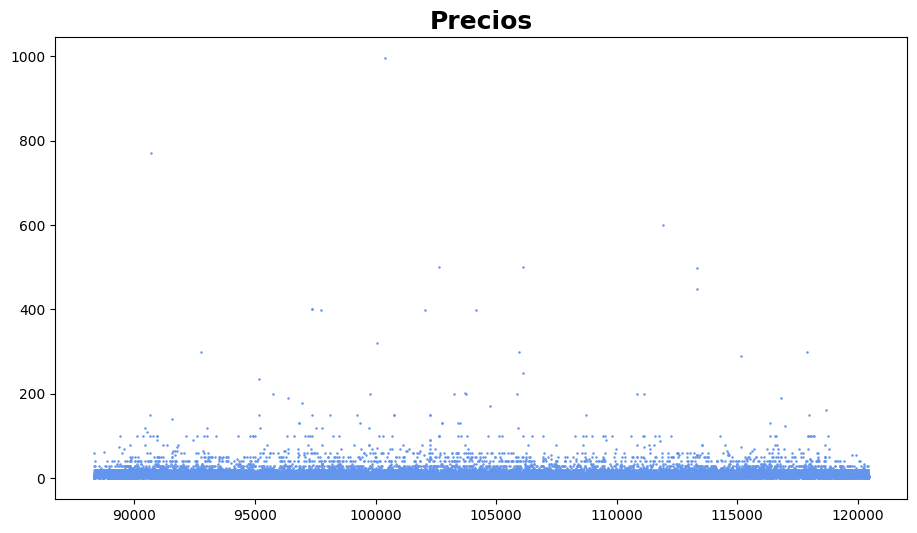

In [34]:
plt.figure(figsize=(11,6))
plt.plot(games['price'],'o',markersize=0.8,color='cornflowerblue')
plt.title('Precios', fontweight = 'bold',fontsize=18)
plt.show()

A partir del histograma se puede observar que la mayoria de precios son menores a $20, sin embargo tambien se puede observar que los valores se concentran en los valores cerrados (ej. $30.00) y con 50 centavos (ej. 30.50)

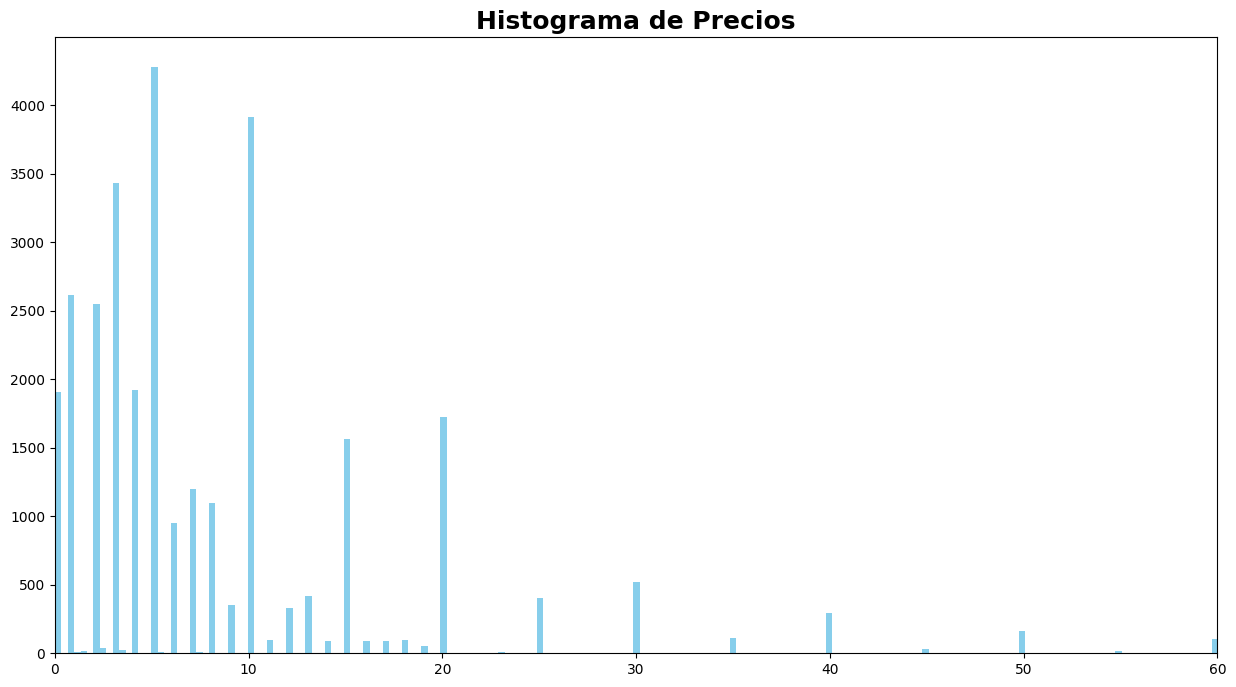

In [35]:
plt.figure(figsize=(15,8))
plt.hist(games['price'],bins=3000,color='skyblue')
plt.title('Histograma de Precios', fontweight = 'bold',fontsize=18)
plt.xlim(0,60)
plt.show()

#### Analisis de BoxPlot 'Price'

Se decició hacer un analisis de BoxPlot para identificar los outliers en el DataFrame. Se obtuvo que los valores por encima de los $20.49 se considerarian como valores extremos. De acuerdo con esto, se obtuvo que existian 1.884 outlier lo cual representa el 5.86% de los datos. Sin embargo, al analizar los valores de los datos que serian excluidos se considero que eran valores relevantes para el analisis por lo cual no se elimino ningun valor siguiendo este criterio.

In [36]:
#Calculo de bigotes
Q3 = float(games['price'].quantile(0.75))
Q1 = float(games['price'].quantile(0.25))
RIC = Q3 - Q1

min_price = Q1 - 1.5*RIC
if min_price < min(games['price']):
    min_price = min(games['price'])
max_price = Q3 + 1.5*RIC
if max_price > max(games['price']):
    max_price = max(games['price'])

min_price, max_price

(0.0, 20.490000000000002)

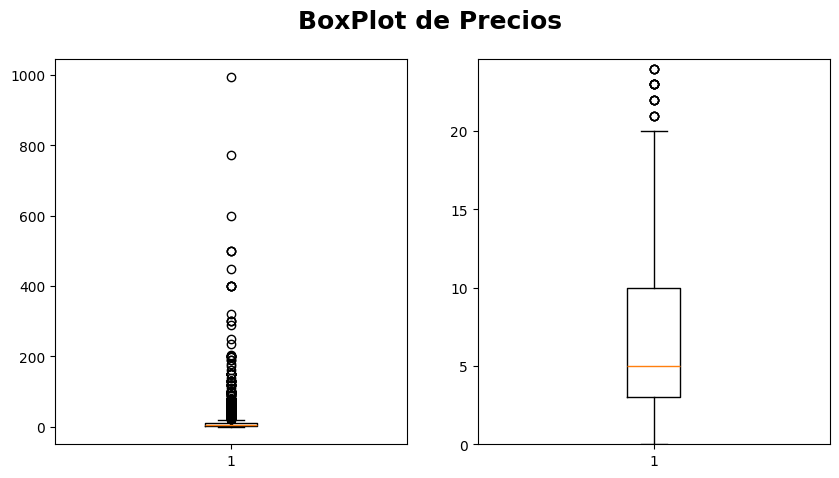

In [37]:
fig, ax = plt.subplots(1, 2,figsize = (10,5))
fig.suptitle('BoxPlot de Precios',fontsize=18, fontweight='bold')

ax[0].boxplot(games['price'].dropna())

ax[1].boxplot(games['price'].dropna())
ax[1].set_ylim(min_price*0.8, max_price*1.2)

plt.show()

In [38]:
print('Cantidad de outliers:', games[games['price']>=max_price].shape[0])
print('Porcentaje de outliers:',(games[games['price']>=max_price].shape[0]/games.shape[0])*100,'%')

Cantidad de outliers: 1884
Porcentaje de outliers: 5.863496311972861 %


In [39]:
games[games['price']>=max_price]

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year
88318,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Legend Pass,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",29.99,0.0,774278.0,Poppermost Productions,2018.0
88328,"[Free to Play, Indie, Simulation, Sports]",SNOW - Lifetime Pack,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",59.99,0.0,774279.0,Poppermost Productions,2018.0
88361,None,Medicalholodeck Personal Version,[Education],"[Tracked Motion Controllers, Seated, Standing]",29.99,0.0,769350.0,None,NaN
88369,[Racing],RACE - The WTCC Game,"[Racing, Simulation]","[Single-player, Multi-player]",39.99,0.0,4230.0,SimBin,2006.0
88544,"[Massively Multiplayer, RPG]",Guild Wars Trilogy,"[RPG, Massively Multiplayer, MMORPG, PvP]","[Multi-player, MMO]",29.99,0.0,29570.0,ArenaNet®,2008.0
...,...,...,...,...,...,...,...,...,...
120248,"[RPG, Simulation]",愛神餐館2,"[RPG, Simulation, Anime]",[Single-player],34.99,0.0,769680.0,Firedog Creative Company Limited,2017.0
120266,None,Three Kingdoms VR - Jade Knight (光之三國VR - 青龍騎),"[Action, Casual, Simulation, Sports]","[Single-player, Steam Achievements, Steam Clou...",24.99,0.0,731120.0,None,NaN
120269,"[Massively Multiplayer, Racing, Simulation, Sp...",CarX Drift Racing Online - Deluxe,"[Massively Multiplayer, Simulation, Racing, Sp...","[Single-player, Multi-player, Online Multi-Pla...",29.99,0.0,776950.0,CarX Technologies,2017.0
120380,"[Action, Adventure, Casual, Indie, Simulation,...",Mesozoica,"[Early Access, Simulation, Strategy, Casual, I...",[Single-player],29.99,1.0,719590.0,"DreamInCode B.V.,Squadron Interactive",2018.0


In [40]:
pd.set_option('display.max_rows', None)
print(games['price'].value_counts().sort_index(ascending=True))
pd.reset_option('display.max_rows')

price
0.00      1908
0.49         2
0.50         1
0.89         1
0.95         1
0.98         2
0.99      2607
1.00         4
1.25         3
1.29         2
1.39         1
1.49         9
1.50         1
1.59         3
1.87         1
1.95         1
1.99      2541
2.00         3
2.30         1
2.49        38
2.66         1
2.89         1
2.97         1
2.99      3429
3.00         1
3.33         2
3.39         1
3.49        19
3.99      1918
4.00         1
4.29         1
4.49         4
4.68         1
4.99      4278
5.00         2
5.49         7
5.65         1
5.99       948
6.00         1
6.48         1
6.49         1
6.66         1
6.99      1199
7.00         1
7.49        11
7.99      1095
8.98         1
8.99       347
9.00         1
9.69         1
9.95         1
9.98         1
9.99      3902
10.00        5
10.49        1
10.93        1
10.96        1
10.99       93
11.15        1
11.99      331
12.00        1
12.89        1
12.99      417
13.37        1
13.98        1
13.99       92
14.9

### Early_access

La variable **'early_access'** es un identificar de acceso temprano. Esta toma exclusivamente 2 valores: 1 para items que poseen acceso temprano y 0 para los que no. Esta columna no contenia valores nulos y se encontro que el 93.9% de los juegos tienen esta caracteristica y el 6.1% restante no.

In [41]:
games['early_access'].value_counts()

early_access
0.0    30184
1.0     1947
Name: count, dtype: int64

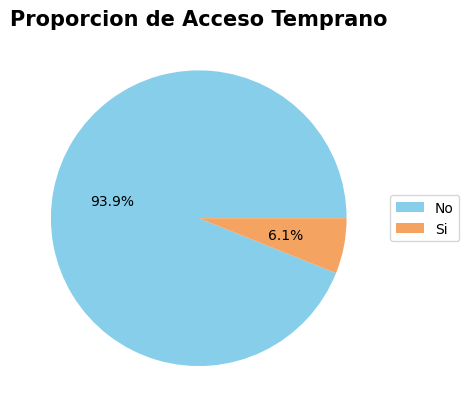

In [42]:
plt.pie(games['early_access'].value_counts(),autopct='%1.1f%%',colors=['skyblue','sandybrown'])
plt.title('Proporcion de Acceso Temprano',fontsize=15,fontweight='bold')
plt.legend(['No','Si'],loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Developer

La columna **'developer'* corresponde a la empresa desarrolladora del juego. Se tiene 3.297 valores nulos para esta variable y un total de 10.993 desarrolladoras. Las 5 principales empresas son *Ubisoft - San Francisco* que desarrolla 1.259 juegos (el 3.92%), *SmiteWorks USA,LLC* 813 (2.53%), *Dovetail Games* 253 (0.79%), *KOEI TECMO GAMES CO., LTD.* 232 (0.72%) y *Paradox Development Studio* 156 (0.48%)

In [43]:
games['developer'].isnull().sum()

np.int64(3297)

In [43]:
np.size(games['developer'].unique())

10993

In [44]:
games['developer'].value_counts()

developer
Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
                              ... 
Tony Wang                        1
Trokardia                        1
Sai Attack                       1
Cyber Prophet                    1
Wrecked Angle Studios            1
Name: count, Length: 10992, dtype: int64

A continuacion se pueden observar las 15 empresas que desarrollan el mayor numero de juegos presentes en la base de datos.

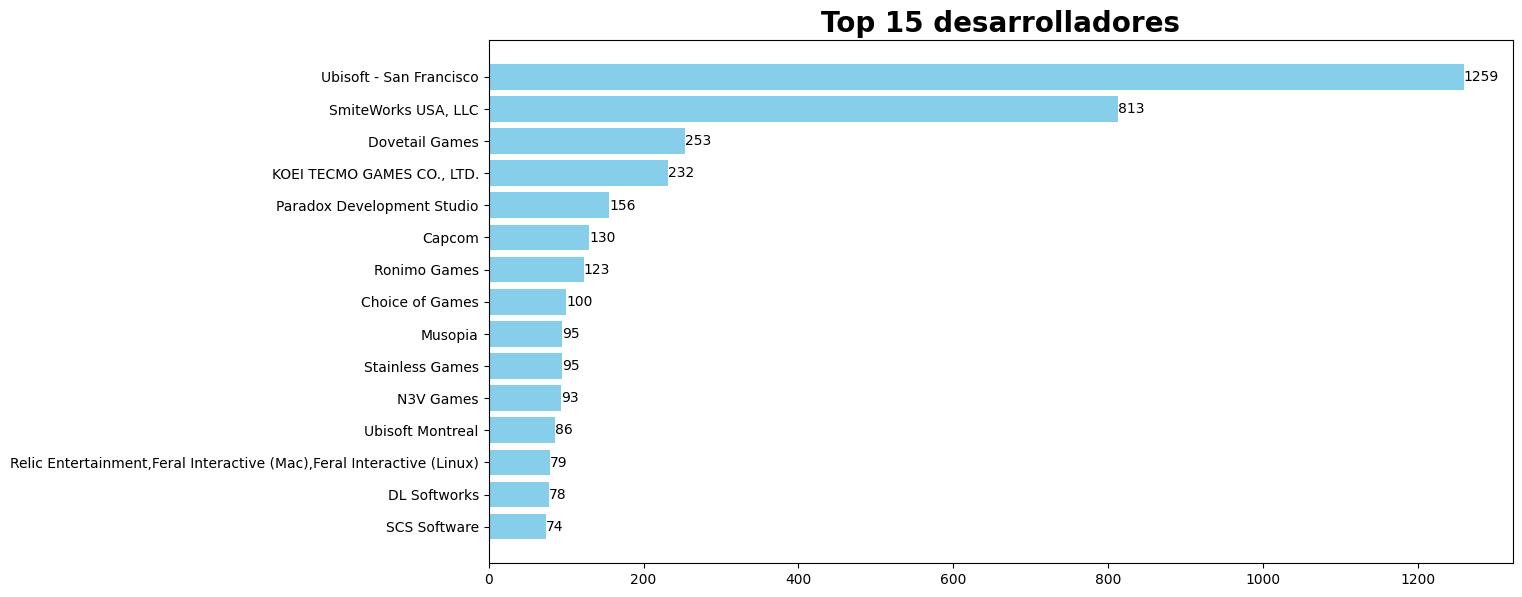

In [45]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(games['developer'].dropna().value_counts().head(15).index,games['developer'].dropna().value_counts().head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 desarrolladores', fontweight = 'bold',fontsize=20)
for index, value in enumerate(games['developer'].dropna().value_counts().head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Release_year

Esta variable corresponde al año en el cual fue lanzado el juego. Este dataset contiene juego desarrollados en un periodo entre 1970 y 2021, excluyendo los años 1971, 1971, 1973, 1974, 1976, 1977, 1978, 1979 y 2020. La columna contiene 2.170 valores nulos.

In [50]:
games['release_year'].isnull().sum()

np.int64(2170)

In [46]:
games['release_year'].unique().size

44

In [47]:
games['release_year'].value_counts().sort_index(ascending=True)

release_year
1970.0       2
1975.0       1
1980.0       1
1981.0       3
1982.0       3
1983.0       4
1984.0       4
1985.0       3
1986.0       1
1987.0       9
1988.0       7
1989.0      10
1990.0      12
1991.0      16
1992.0      15
1993.0      34
1994.0      36
1995.0      33
1996.0      39
1997.0      42
1998.0      61
1999.0      55
2000.0      40
2001.0      69
2002.0      50
2003.0      84
2004.0      79
2005.0     102
2006.0     155
2007.0     167
2008.0     213
2009.0     341
2010.0     442
2011.0     590
2012.0    1192
2013.0    1552
2014.0    2843
2015.0    4952
2016.0    6943
2017.0    9594
2018.0     157
2019.0       4
2021.0       1
Name: count, dtype: int64

En el grafico a continuacion se puede observar que los lanzamientos de juegos de la plataforma presento un crecimiento exponencial que llego a su punto maximo en 2017 para luego tener un descenso abrupto del 2018 en adelante, incluso con ningun juego lanzado en el año 2020.

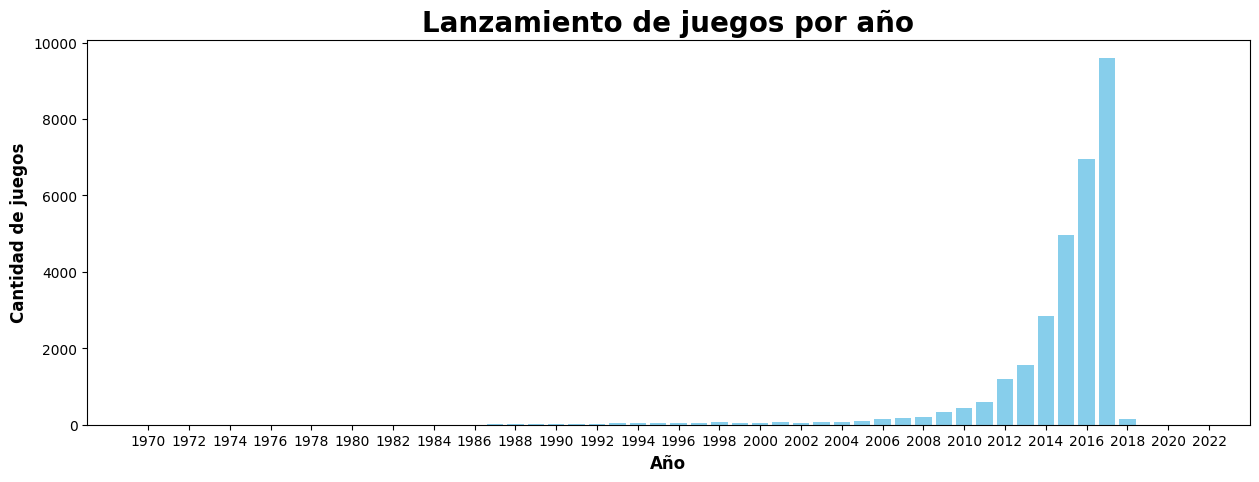

In [48]:
plt.figure(figsize=(15,5))
plt.bar(games['release_year'].value_counts().index,games['release_year'].value_counts().values,color='skyblue')
plt.title('Lanzamiento de juegos por año',fontweight = 'bold',fontsize=20)
plt.xlabel('Año',fontweight = 'bold',fontsize=12)
plt.ylabel('Cantidad de juegos',fontweight = 'bold',fontsize=12)
plt.xticks(ticks=list(range(1970,2023,2)))
plt.show()

### Analisis de Correlacion Games

A continuacion se presenta un analisis de correlacion entre las columnas numericas del DataFrame. Inicialmente se realizo un analisis con las variables **'price'**, **'early_access'** y **'release_year'** ya que el **'item_id'** es el identificador del juego y no presenta ninguna correlacion con las demas variables. Se puede entre las variables es muy cercana a cero por lo que se considera no existe correlacion entre ellas. Con el fin de realizar un analisis mas concienzudo se decició tener en cuenta mas variables. De acuerdo con esto se realizo un analisis **por separado** de [**'genres'**](#con-generos---genres) y [**'specs'**](#con-especificaciones---specs).

In [52]:
correlacion=games[['price','early_access','release_year']].corr()
correlacion

,price,early_access,release_year
price,1.000000,0.016792,0.015136
early_access,0.016792,1.000000,0.095429
release_year,0.015136,0.095429,1.000000


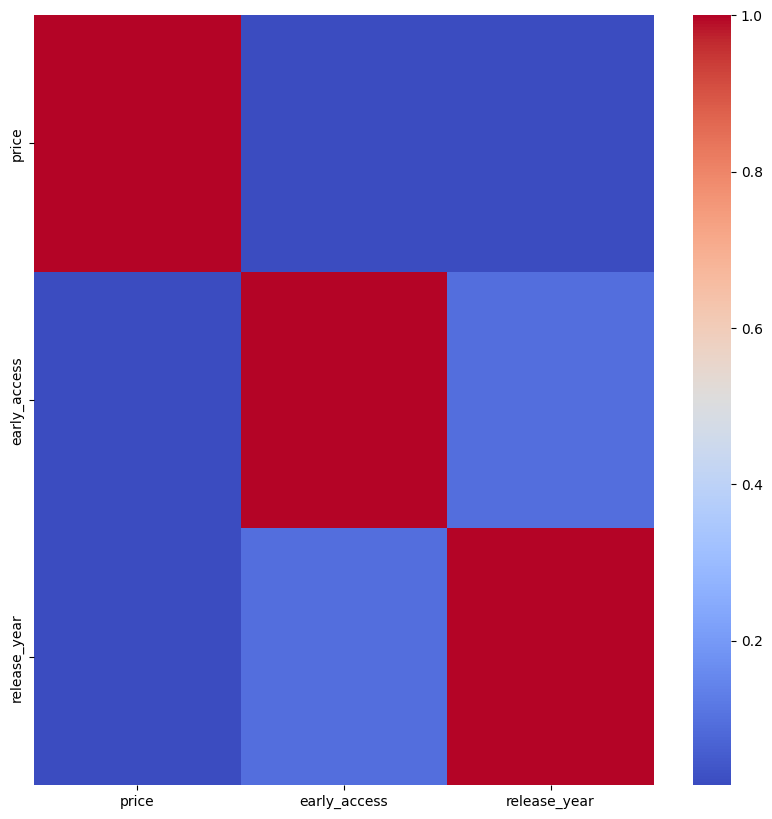

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm')
plt.show()

In [54]:
games_gen = games.copy()
games_specs = games.copy()

#### Con Generos - Genres

Para realizar este analisis se modifico el DataFrame para poder incluir cada genero existente por separado en el modelo. Nuevamente se excluyo el *item_id* a pesar de ser una variable numerica.

In [55]:
games_gen['genres'] = games_gen['genres'].apply(lambda x: x if isinstance(x, np.ndarray) else [])

mlb = MultiLabelBinarizer()

genres_dummies = pd.DataFrame(mlb.fit_transform(games_gen['genres']), columns=mlb.classes_, index=games_gen.index)

games_gen = pd.concat([games_gen, genres_dummies], axis=1)

games_gen

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year,Accounting,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0,0,...,0,0,0,1,0,0,1,0,0,0
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0,0,...,0,1,0,0,0,0,1,0,0,0
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,2017.0,0,...,0,0,0,1,0,1,0,0,0,0
88313,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0.0,767400.0,彼岸领域,2017.0,0,...,0,0,0,0,0,0,0,0,0,0
88314,[],Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,NaN,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0,0,...,0,0,0,1,0,0,1,0,0,0
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0,0,...,0,0,0,0,0,0,1,0,0,0
120442,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0,0,...,0,0,1,1,0,0,0,0,0,0
120443,"[Casual, Indie]",EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns",2017.0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
correlacion=games_gen.drop(columns=['genres','item_name','tags','specs','developer','item_id','Early Access']).corr()
correlacion

,price,early_access,release_year,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
price,1.000000,0.016792,0.015136,0.026738,-0.034403,-0.038502,0.222868,0.101345,-0.121792,0.152462,...,0.051344,0.026751,-0.006230,0.030594,0.078702,0.016822,0.004067,0.143893,0.154712,0.096408
early_access,0.016792,1.000000,0.095429,-0.003749,0.043743,-0.002817,-0.003621,-0.008827,-0.046182,-0.015235,...,-0.012448,0.019422,0.011836,-0.002547,-0.007686,0.007287,-0.001129,-0.005868,-0.010938,-0.021858
release_year,0.015136,0.095429,1.000000,0.006613,0.011996,0.052853,0.016884,0.009315,0.107869,0.031906,...,0.011423,0.062994,0.007386,0.040374,0.010181,0.054869,0.004943,0.023700,0.016211,0.018076
Accounting,0.026738,-0.003749,0.006613,1.000000,-0.010886,-0.008671,0.026906,0.038459,-0.008699,0.015973,...,0.042406,-0.006693,-0.002757,-0.007576,0.036105,-0.002979,-0.007760,0.039693,0.034272,0.021833
Action,-0.034403,0.043743,0.011996,-0.010886,1.000000,0.150657,-0.054945,-0.039731,-0.111019,-0.088324,...,-0.036143,-0.009347,0.015711,-0.211986,-0.042224,-0.019079,-0.142305,-0.076261,-0.044388,-0.067630
Adventure,-0.038502,-0.002817,0.052853,-0.008671,0.150657,1.000000,-0.044455,-0.031647,0.061191,-0.070789,...,-0.028789,0.131616,-0.061920,-0.153395,-0.033633,-0.071470,-0.110144,-0.060744,-0.035357,-0.053869
Animation &amp; Modeling,0.222868,-0.003621,0.016884,0.026906,-0.054945,-0.044455,1.000000,0.057510,-0.042709,0.446956,...,0.097792,-0.034315,-0.014135,-0.038844,0.357994,-0.015271,-0.039787,0.404447,0.298850,0.184051
Audio Production,0.101345,-0.008827,0.009315,0.038459,-0.039731,-0.031647,0.057510,1.000000,-0.029101,0.027645,...,0.021056,-0.024428,-0.010063,-0.026226,0.159329,-0.010871,-0.028323,0.305830,0.354150,0.052389
Casual,-0.121792,-0.046182,0.107869,-0.008699,-0.111019,0.061191,-0.042709,-0.029101,1.000000,-0.071020,...,-0.028883,-0.120753,-0.026081,0.187993,-0.033742,0.045874,-0.024223,-0.059552,-0.035472,-0.054045
Design &amp; Illustration,0.152462,-0.015235,0.031906,0.015973,-0.088324,-0.070789,0.446956,0.027645,-0.071020,1.000000,...,0.363817,-0.054643,-0.022508,-0.061853,0.245582,-0.024318,-0.063355,0.427941,0.123793,0.674563


A continuacion se presenta la grafica de correlacion de las matrices. Se puede observar que existen variables que no presenta relacion con ninguna como *'early_access'*, *'release_year'* y el genero *'Accounting'*. Por otro lado, se presentan correlaciones fuertes como la de los generos *'Design &amp; Illustration'* y *'Web Publishing'* con un 0.6745 y *'Education'* y *'Software Training'* con un 0.5745. Tambien se encontraron algunos valores negativos sin embargo el mayor valor es alrededor de un -0.2. Algunos de los generos que presentan este tipo de correlacion son *'Action'* y *'Adventure'* con *'Simulation'* con un -0.211986 y un -0.153395, respectivamente. 

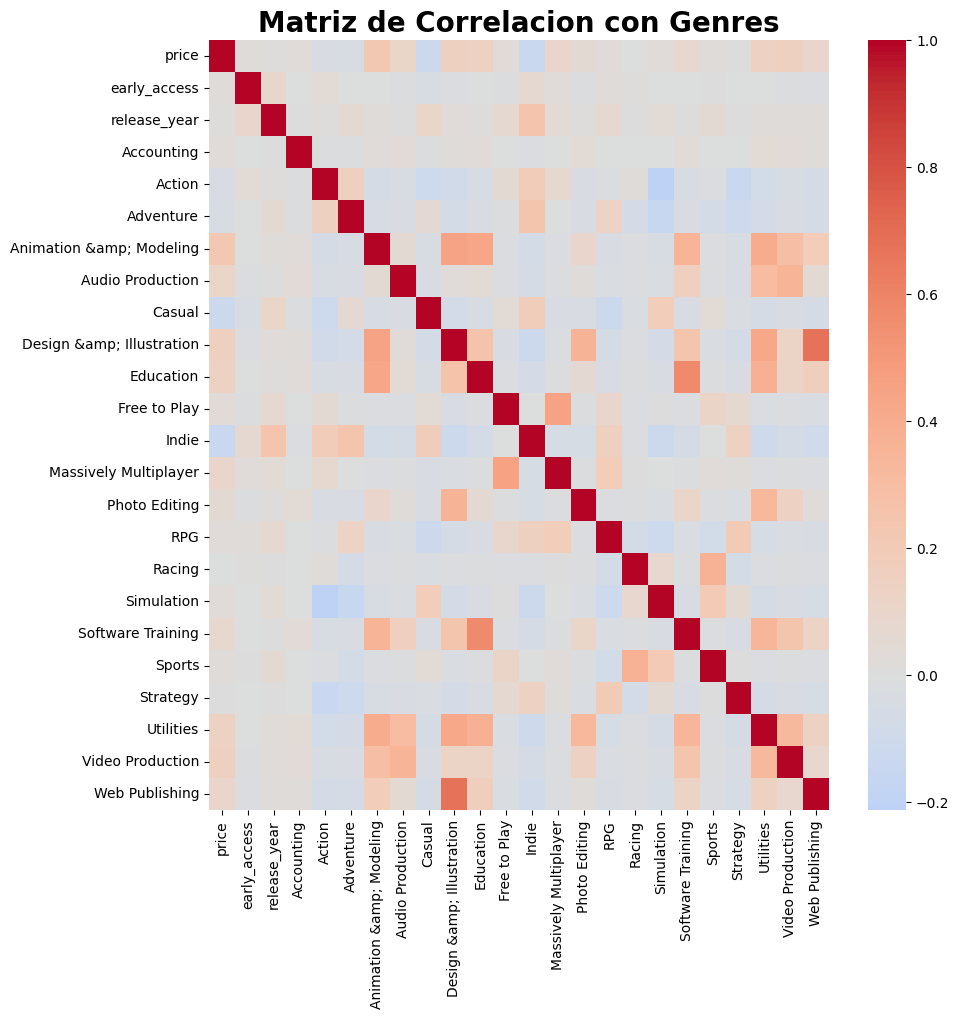

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm',center=0)
plt.title('Matriz de Correlacion con Genres', fontweight = 'bold',fontsize=20)
plt.show()

#### Con Especificaciones - Specs

Para realizar este analisis se modifico el DataFrame para poder incluir cada especificacion existente (44 en total) por separado en el modelo. Nuevamente se excluyo el *item_id* a pesar de ser una variable numerica.

In [53]:
games_specs['specs'] = games_specs['specs'].apply(lambda x: x if isinstance(x, np.ndarray) else [])

mlb = MultiLabelBinarizer()

specs_dummies = pd.DataFrame(mlb.fit_transform(games_specs['specs']), columns=mlb.classes_, index=games_specs.index)

games_specs = pd.concat([games_specs, specs_dummies], axis=1)

games_specs

,genres,item_name,tags,specs,price,early_access,item_id,developer,release_year,Captions available,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0,0,...,0,0,0,0,0,0,0,0,0,0
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0,0,...,1,0,0,1,0,0,0,0,0,0
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,2017.0,0,...,0,0,0,0,0,0,0,0,0,0
88313,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0.0,767400.0,彼岸领域,2017.0,0,...,0,0,0,0,0,0,0,0,0,0
88314,None,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,NaN,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0,0,...,1,0,0,0,0,0,0,0,0,0
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0,0,...,1,1,1,0,0,0,0,0,0,0
120442,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0,0,...,1,0,0,1,0,0,0,0,0,0
120443,"[Casual, Indie]",EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns",2017.0,0,...,1,1,0,0,0,0,0,0,0,0


In [67]:
correlacion=games_gen.drop(columns=['genres','item_name','tags','specs','developer','item_id','Early Access']).corr()

In [69]:
correlacion

,price,early_access,release_year,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
price,1.000000,0.016792,0.015136,0.026738,-0.034403,-0.038502,0.222868,0.101345,-0.121792,0.152462,...,0.051344,0.026751,-0.006230,0.030594,0.078702,0.016822,0.004067,0.143893,0.154712,0.096408
early_access,0.016792,1.000000,0.095429,-0.003749,0.043743,-0.002817,-0.003621,-0.008827,-0.046182,-0.015235,...,-0.012448,0.019422,0.011836,-0.002547,-0.007686,0.007287,-0.001129,-0.005868,-0.010938,-0.021858
release_year,0.015136,0.095429,1.000000,0.006613,0.011996,0.052853,0.016884,0.009315,0.107869,0.031906,...,0.011423,0.062994,0.007386,0.040374,0.010181,0.054869,0.004943,0.023700,0.016211,0.018076
Accounting,0.026738,-0.003749,0.006613,1.000000,-0.010886,-0.008671,0.026906,0.038459,-0.008699,0.015973,...,0.042406,-0.006693,-0.002757,-0.007576,0.036105,-0.002979,-0.007760,0.039693,0.034272,0.021833
Action,-0.034403,0.043743,0.011996,-0.010886,1.000000,0.150657,-0.054945,-0.039731,-0.111019,-0.088324,...,-0.036143,-0.009347,0.015711,-0.211986,-0.042224,-0.019079,-0.142305,-0.076261,-0.044388,-0.067630
Adventure,-0.038502,-0.002817,0.052853,-0.008671,0.150657,1.000000,-0.044455,-0.031647,0.061191,-0.070789,...,-0.028789,0.131616,-0.061920,-0.153395,-0.033633,-0.071470,-0.110144,-0.060744,-0.035357,-0.053869
Animation &amp; Modeling,0.222868,-0.003621,0.016884,0.026906,-0.054945,-0.044455,1.000000,0.057510,-0.042709,0.446956,...,0.097792,-0.034315,-0.014135,-0.038844,0.357994,-0.015271,-0.039787,0.404447,0.298850,0.184051
Audio Production,0.101345,-0.008827,0.009315,0.038459,-0.039731,-0.031647,0.057510,1.000000,-0.029101,0.027645,...,0.021056,-0.024428,-0.010063,-0.026226,0.159329,-0.010871,-0.028323,0.305830,0.354150,0.052389
Casual,-0.121792,-0.046182,0.107869,-0.008699,-0.111019,0.061191,-0.042709,-0.029101,1.000000,-0.071020,...,-0.028883,-0.120753,-0.026081,0.187993,-0.033742,0.045874,-0.024223,-0.059552,-0.035472,-0.054045
Design &amp; Illustration,0.152462,-0.015235,0.031906,0.015973,-0.088324,-0.070789,0.446956,0.027645,-0.071020,1.000000,...,0.363817,-0.054643,-0.022508,-0.061853,0.245582,-0.024318,-0.063355,0.427941,0.123793,0.674563


En el siguiente grafico se puede observar que existen valores de correlacion mayores para estas variables que en los casos anteriores. Se puede identificar variables como *'Animation &amp; Modeling'*, *'Education'* y *'Utilities'* que presentan correlacion con varias variables. Nuevamente las correlaciones mas fuertes se presentan entre *'Design &amp; Illustration'* y *'Web Publishing'*, y *'Education'* y *'Software Training'*. Se presentar nuevas correlaciones que llaman la atencion como la de *'Audio Production'* y *'Video Production'*. 

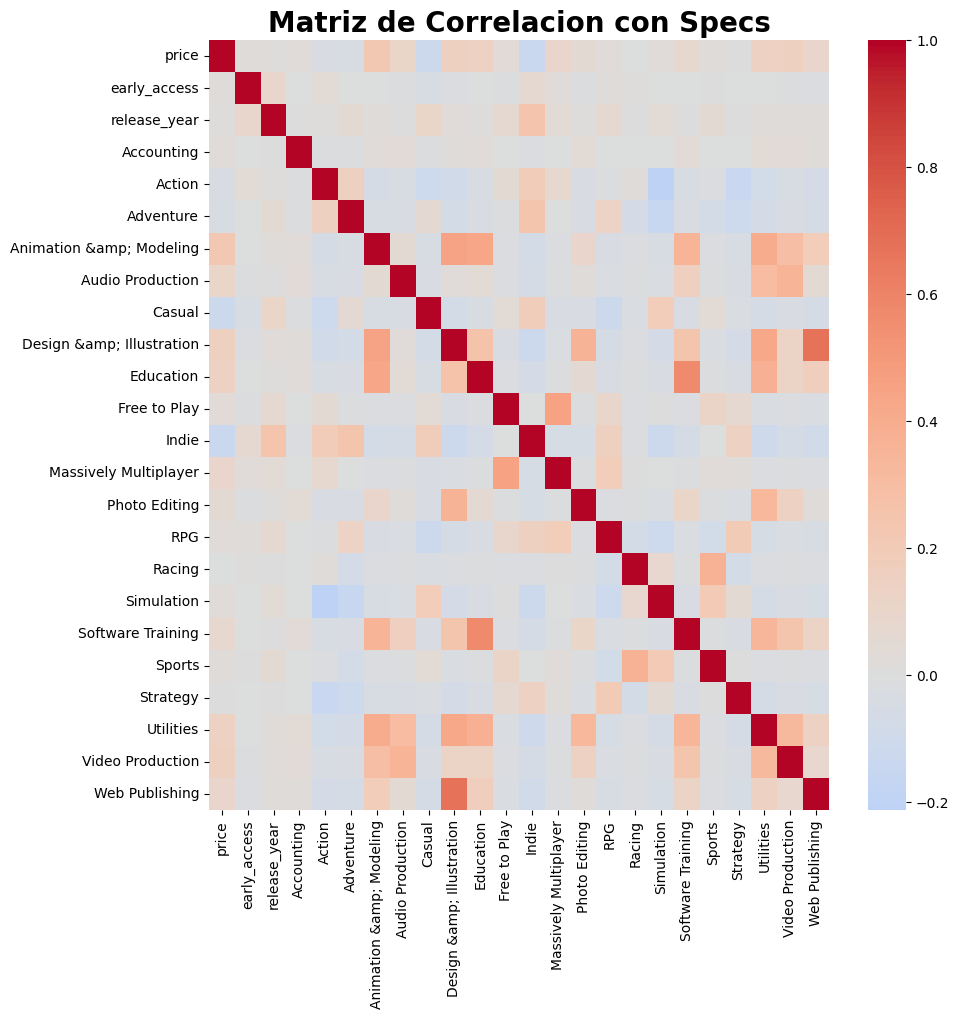

In [68]:
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm',center=0)
plt.title('Matriz de Correlacion con Specs', fontweight = 'bold',fontsize=20)
plt.show()

## Analisis de Items

En esta seccion se encuentra todo el analisis de las columnas del DataFrame **Items**. Tenemos inicialmente 120.445 registros y 9 columnas con 3 tipos de datos: listas (genres, tags y specs), float (price, early_access, item_id y release_year) y string (item_name y developer). No se realizó analisis de la columna **'item_id'** ya que es el identificador unico del juego, no presenta repetidos ni tendencias.

In [55]:
items.head()

,user_id,item_id,item_name,playtime
0,76561197970982479,10.0,Counter-Strike,0.100000
1,76561197970982479,20.0,Team Fortress Classic,0.000000
2,76561197970982479,30.0,Day of Defeat,0.116667
3,76561197970982479,40.0,Deathmatch Classic,0.000000
4,76561197970982479,50.0,Half-Life: Opposing Force,0.000000


In [56]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    float64
 2   item_name  object 
 3   playtime   float64
dtypes: float64(2), object(2)
memory usage: 157.8+ MB


### Manejo de nulos

In [57]:
items.isnull().sum()

user_id          0
item_id      16806
item_name    16806
playtime     16806
dtype: int64

In [58]:
#Se borraron 16.806 nulos
items.dropna(inplace=True)

### Manejo de duplicados

In [59]:
#Se borran 59.104 duplicados
items.drop(items[items.duplicated()].index,inplace=True)

#### Duplicados user_id + item_name

Se observo que existian registros con el mismo __user_id__ e __item_name__, lo cual indicaba un usuario que habia adquirido el mismo producto dos veces. Sin embargo, estos registros tenian diferente __item_id__. Se decidio hacer una referenciacion cruzada con el DataFrame __*Games*__ y se encontro que el item_name estaba relacionado solo con uno de los __item_id__. Por lo tanto, se dedcidio eliminar los datos duplicados cuyo __item_id__ no existiera en __*Games*__.

In [60]:
#Variable que contiene los regisgtros duplicados de items segun user_id y item_name de la tabla Items
dup=items[items.duplicated(subset=['user_id','item_name'])]
dup

,user_id,item_id,item_name,playtime
13,76561197970982479,34440.0,Sid Meier's Civilization IV,0.0
361,js41637,34440.0,Sid Meier's Civilization IV,0.0
496,js41637,34450.0,Sid Meier's Civilization IV: Warlords,0.0
497,js41637,34460.0,Sid Meier's Civilization IV: Beyond the Sword,0.0
1333,Riot-Punch,12230.0,Grand Theft Auto III,0.0
...,...,...,...,...
5166906,ChrisCoroner,12250.0,Grand Theft Auto: San Andreas,0.0
5167041,elasticgoose,12230.0,Grand Theft Auto III,0.0
5167042,elasticgoose,12240.0,Grand Theft Auto: Vice City,0.0
5167043,elasticgoose,12250.0,Grand Theft Auto: San Andreas,0.0


In [61]:
#Variable que contiene los registros duplicados de la tabla Items que tienen item_id en Games
ambas = dup.merge(games,on='item_id',how='inner',suffixes=('_items','_games'))
ambas

,user_id,item_id,item_name_items,playtime,genres,item_name_games,tags,specs,price,early_access,developer,release_year
0,76561198076248461,33900.0,Arma 2,11.033333,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
1,76561198085956238,33900.0,Arma 2,42.800000,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
2,Bluegills,33900.0,Arma 2,0.000000,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
3,76561198051215704,33900.0,Arma 2,0.616667,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
4,chidvd,345130.0,Dark Matter,0.000000,"[Action, Casual, Indie]",Dark Matter,"[Casual, Action, Indie, Shoot 'Em Up, 2D, Arca...","[Single-player, Partial Controller Support]",4.99,0.0,Meridian4,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...
94,76561198074807900,33900.0,Arma 2,2.983333,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
95,76561198077366528,33900.0,Arma 2,0.000000,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
96,76561198079522604,33900.0,Arma 2,0.100000,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0
97,crazyshockbrain,33900.0,Arma 2,0.000000,"[Action, Simulation, Strategy]",Arma 2,"[Simulation, Military, Action, Multiplayer, Ta...","[Single-player, Multi-player, Co-op, Captions ...",12.99,0.0,Bohemia Interactive,2009.0


In [62]:
# Se verifica si se encuentran duplicados
ambas[ambas.duplicated(subset=['user_id','item_name_items'])]

,user_id,item_id,item_name_items,playtime,genres,item_name_games,tags,specs,price,early_access,developer,release_year


No se encuentran duplicados entre estas dos tablas auxilidares, lo que indica que el item no existe dos veces en Games. Por lo tanto, se considera dejar un solo valor para cada duplicado. Para determinar que registro conservar se tomo el que tuviera mayor valor en 'playtime'. Se borraron 20.366 registros.

In [63]:
# Variable con todos los duplicados
dup_all=items[items.duplicated(subset=['user_id','item_name'],keep=False)]
dup_all

,user_id,item_id,item_name,playtime
12,76561197970982479,3900.0,Sid Meier's Civilization IV,5.633333
13,76561197970982479,34440.0,Sid Meier's Civilization IV,0.000000
360,js41637,3900.0,Sid Meier's Civilization IV,1.400000
361,js41637,34440.0,Sid Meier's Civilization IV,0.000000
493,js41637,3990.0,Sid Meier's Civilization IV: Warlords,0.000000
...,...,...,...,...
5167041,elasticgoose,12230.0,Grand Theft Auto III,0.000000
5167042,elasticgoose,12240.0,Grand Theft Auto: Vice City,0.000000
5167043,elasticgoose,12250.0,Grand Theft Auto: San Andreas,0.000000
5167395,943525,12120.0,Grand Theft Auto: San Andreas,4.516667


In [64]:
#Variable que contiene los menores valores entre el par de duplicados
d_min=dup_all.loc[dup_all.groupby(['item_name', 'user_id'])['playtime'].idxmin()]
d_min

,user_id,item_id,item_name,playtime
2384069,deacansharp,29640.0,Aion,13.700000
977657,76561197981425218,33900.0,Arma 2,0.000000
1828510,76561197990997704,33900.0,Arma 2,0.000000
3424933,76561197992413659,33910.0,Arma 2,0.000000
655781,76561197993591260,33910.0,Arma 2,0.000000
...,...,...,...,...
3897458,stooged,48160.0,Tom Clancy's H.A.W.X. 2,0.000000
3489114,straymav,48160.0,Tom Clancy's H.A.W.X. 2,0.000000
1924345,thugnificent,48160.0,Tom Clancy's H.A.W.X. 2,0.000000
4048573,yuugito,48160.0,Tom Clancy's H.A.W.X. 2,0.000000


In [65]:
items.drop(d_min.index,inplace=True)

### User_id

In [66]:
items['user_id'].value_counts()

user_id
phrostb              7746
thugnificent         6691
chidvd               6399
piepai               6123
mayshowganmore       5021
                     ... 
arifinase               1
76561198073989967       1
76561197988996785       1
76561198086065951       1
76561198086070875       1
Name: count, Length: 70912, dtype: int64

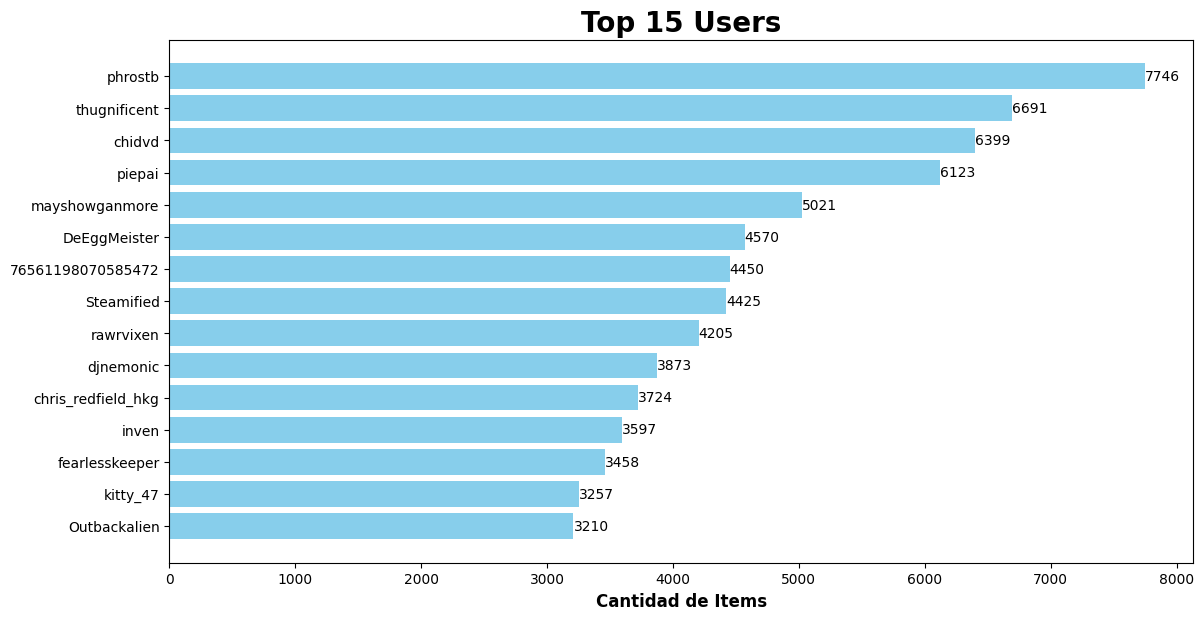

In [67]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(items['user_id'].value_counts().head(15).index,items['user_id'].value_counts().head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Users', fontweight = 'bold',fontsize=20)
plt.xlabel('Cantidad de Items',fontweight = 'bold',fontsize=12)
for index, value in enumerate(items['user_id'].value_counts().head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Item_name

In [68]:
items['item_name'].value_counts()

item_name
Dota 2 Test                          49136
Counter-Strike: Global Offensive     43331
Garry's Mod                          42849
Unturned                             38278
Left 4 Dead 2                        36661
                                     ...  
Mimpi Dreams                             1
Cloudy with a Chance of Meatballs        1
DUCATI - 90th Anniversary                1
SNIPER BLACKLIST                         1
Kim                                      1
Name: count, Length: 10947, dtype: int64

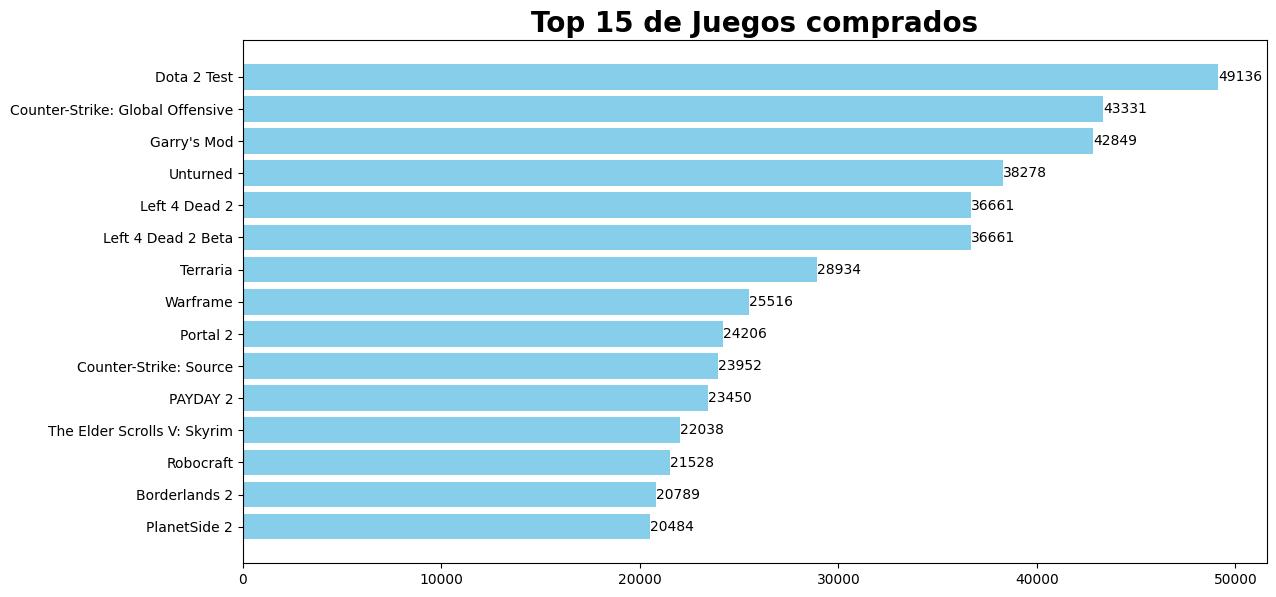

In [69]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(items['item_name'].value_counts().head(15).index,items['item_name'].value_counts().head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 de Juegos comprados', fontweight = 'bold',fontsize=20)
for index, value in enumerate(items['item_name'].value_counts().head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Playtime

In [70]:
pd.options.display.float_format = '{:,.2f}'.format
print(items['playtime'].describe())
pd.reset_option('display.float_format')

count   5,073,726.00
mean           16.57
std            90.41
min             0.00
25%             0.00
50%             0.57
75%             5.97
max        10,712.88
Name: playtime, dtype: float64


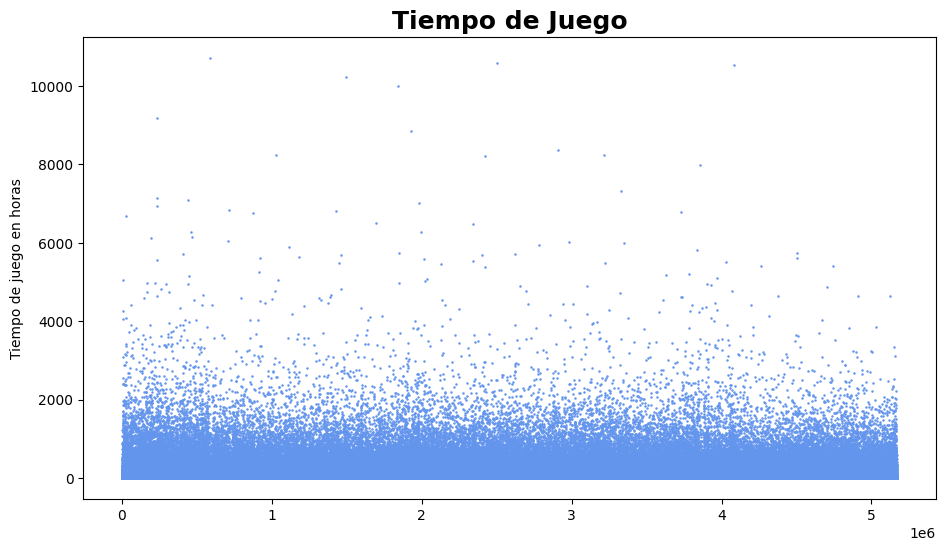

In [71]:
plt.figure(figsize=(11,6))
plt.plot(items['playtime'],'o',markersize=0.8,color='cornflowerblue')
plt.title('Tiempo de Juego', fontweight = 'bold',fontsize=18)
plt.ylabel('Tiempo de juego en horas')
plt.show()

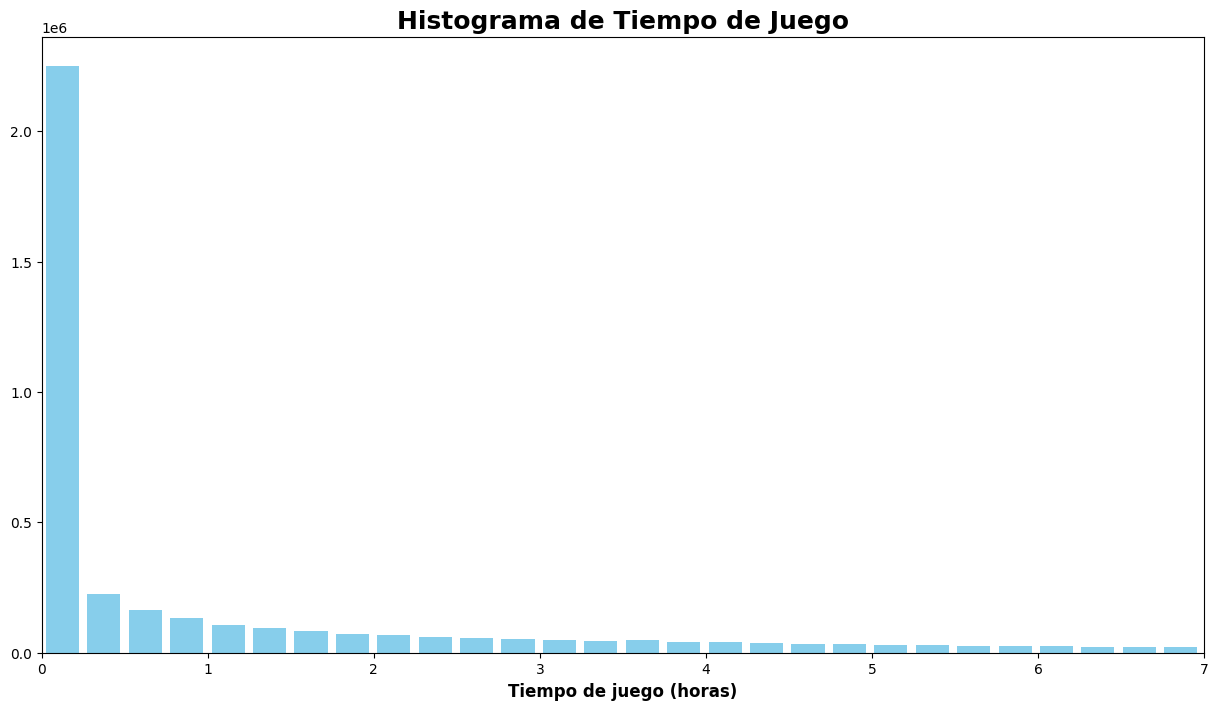

In [72]:
plt.figure(figsize=(15,8))
plt.hist(items[items['playtime']<7].iloc[:,3],bins=28,color='skyblue',rwidth=0.8)
plt.title('Histograma de Tiempo de Juego', fontweight = 'bold',fontsize=18)
plt.xticks(ticks=range(0,16))
plt.xlim(0,7)
plt.xlabel('Tiempo de juego (horas)',fontweight = 'bold',fontsize=12)
plt.show()

In [73]:
print('Cantidad de tiempos en 0:', items[items['playtime']==0].shape[0])
print('Porcentaje de tiempos en 0:',(items[items['playtime']==0].shape[0]/items.shape[0])*100,'%')

Cantidad de tiempos en 0: 1827921
Porcentaje de tiempos en 0: 36.02719185072272 %


In [74]:
pt_sin0 = items[~(items['playtime']==0)].iloc[:,3]

In [75]:
pd.options.display.float_format = '{:,.2f}'.format
print(pt_sin0.describe())
pd.reset_option('display.float_format')

count   3,245,805.00
mean           25.91
std           111.96
min             0.02
25%             0.73
50%             3.42
75%            13.47
max        10,712.88
Name: playtime, dtype: float64


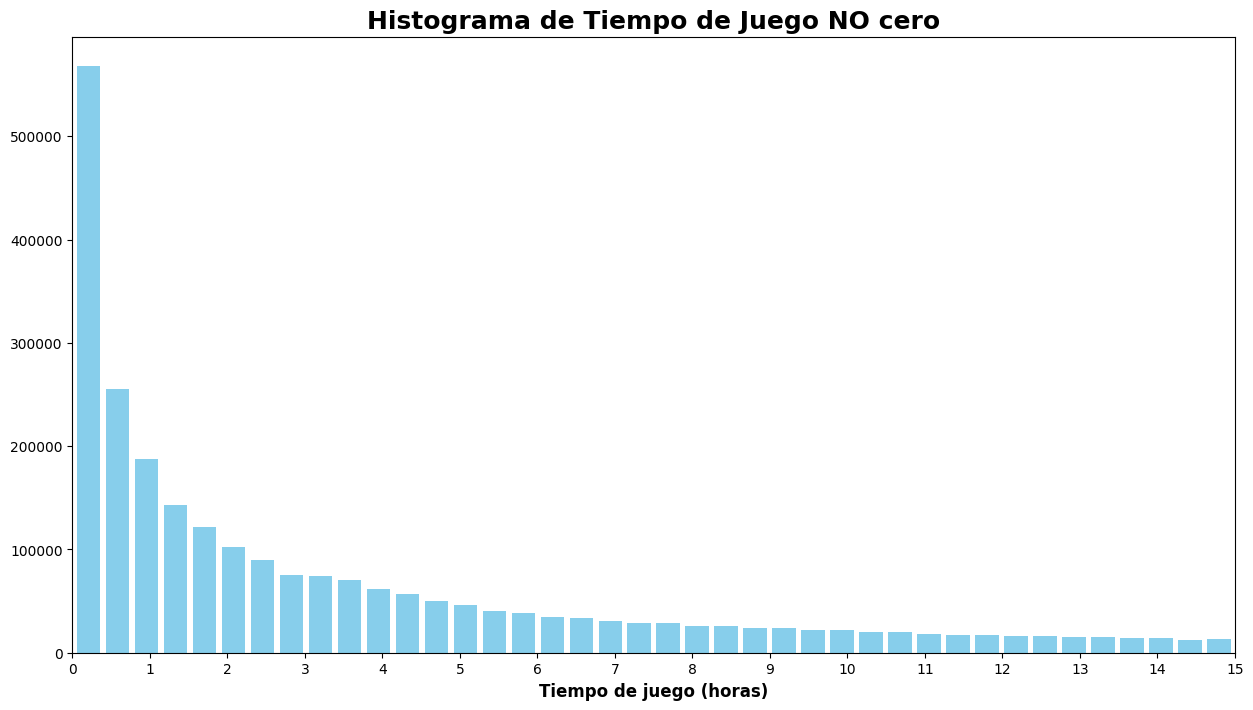

In [76]:
plt.figure(figsize=(15,8))
plt.hist(pt_sin0[pt_sin0<15],bins=40,color='skyblue',rwidth=0.8)
plt.title('Histograma de Tiempo de Juego NO cero', fontweight = 'bold',fontsize=18)
plt.xticks(ticks=range(0,16))
plt.xlim(0,15)
plt.xlabel('Tiempo de juego (horas)',fontweight = 'bold',fontsize=12)
plt.show()

#### Analisis de BoxPlot 'Playtime'

In [77]:
#Calculo de bigotes
Q3 = float(items['playtime'].quantile(0.75))
Q1 = float(items['playtime'].quantile(0.25))
RIC = Q3 - Q1

min_pt = Q1 - 1.5*RIC
if min_pt < min(items['playtime']):
    min_pt = min(items['playtime'])
max_pt = Q3 + 1.5*RIC
if max_pt > max(items['playtime']):
    max_pt = max(items['playtime'])

min_pt, max_pt

(0.0, 14.916666666666666)

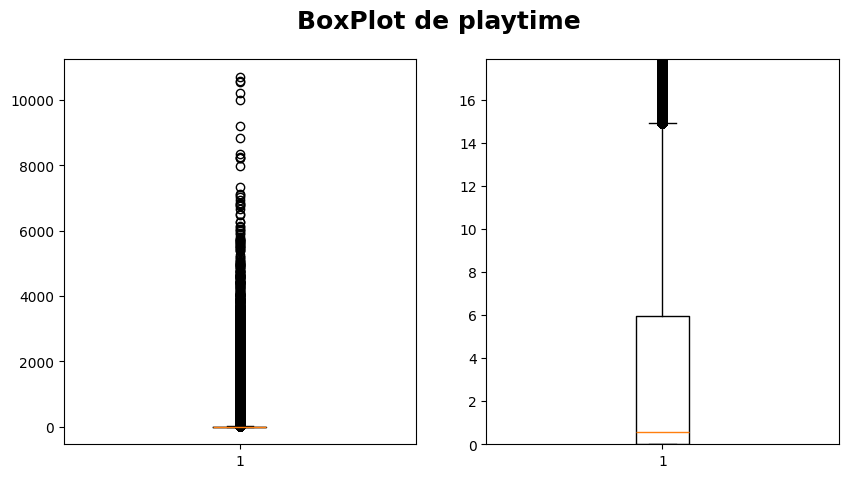

In [78]:
fig, ax = plt.subplots(1, 2,figsize = (10,5))
fig.suptitle('BoxPlot de playtime',fontsize=18, fontweight='bold')

ax[0].boxplot(items['playtime'].dropna())

ax[1].boxplot(items['playtime'].dropna())
ax[1].set_ylim(min_pt*0.8, max_pt*1.2)

plt.show()

In [79]:
print('Cantidad de outliers:', items[items['playtime']>=max_pt].shape[0])
print('Porcentaje de outliers:',(items[items['playtime']>=max_pt].shape[0]/items.shape[0])*100,'%')

Cantidad de outliers: 759652
Porcentaje de outliers: 14.972270871544897 %


In [80]:
#Calculo de bigotes
Q3 = float(pt_sin0.quantile(0.75))
Q1 = float(pt_sin0.quantile(0.25))
RIC = Q3 - Q1

min_pt_0 = Q1 - 1.5*RIC
if min_pt_0 < min(pt_sin0):
    min_pt_0 = min(pt_sin0)
max_pt_0 = Q3 + 1.5*RIC
if max_pt_0 > max(pt_sin0):
    max_pt_0 = max(pt_sin0)

min_pt_0, max_pt_0

(0.016666666666666666, 32.56666666666667)

In [81]:
print('Cantidad de outliers:', pt_sin0[pt_sin0>=max_pt_0].shape[0])
print('Porcentaje de outliers:',(pt_sin0[pt_sin0>=max_pt_0].shape[0]/items.shape[0])*100,'%')

Cantidad de outliers: 431525
Porcentaje de outliers: 8.505090736078378 %


Despues de revisar los resultados del analisis se dedicio no eliminar ninguno registro debido a que al ser un tiempo acumulado en el intervalo de 51 años (primer año de lanzamiento:1970 y ultimo año de lanzamiento: 2021) el valor maximo (10,712.88 horas) corresponderia a un promedio de 17.5 horas al mes. Teniendo en cuenta esto se considero que es posible la existencia de estos valores

### Analisis de Correlacion Items

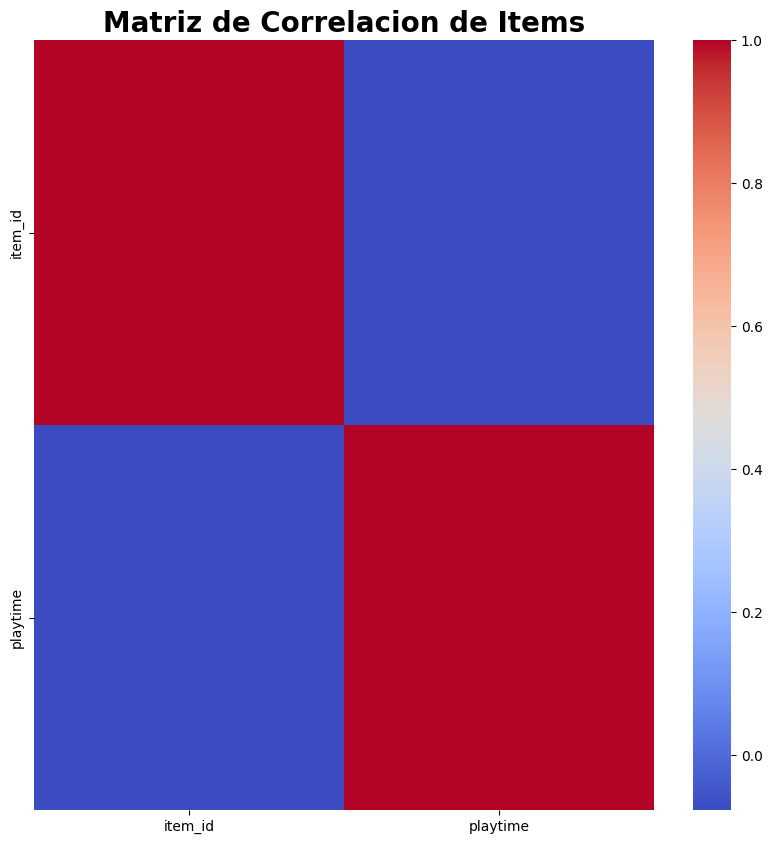

In [82]:
correlacion=items[['item_id','playtime']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm')
plt.title('Matriz de Correlacion de Items', fontweight = 'bold',fontsize=20)
plt.show()

## Analisis de Reviews

In [83]:
reviews

,user_id,item_id,recommend,review,item_name
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2
...,...,...,...,...,...
59328,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life
59329,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa
59330,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies
59331,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive


In [84]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    59333 non-null  object 
 1   item_id    59305 non-null  float64
 2   recommend  59333 non-null  bool   
 3   review     59275 non-null  object 
 4   item_name  52781 non-null  object 
dtypes: bool(1), float64(1), object(3)
memory usage: 1.9+ MB


### Manejo de nulos

In [85]:
reviews.isnull().sum()

user_id         0
item_id        28
recommend       0
review         58
item_name    6552
dtype: int64

In [86]:
#28 registros que tienen datos nulos
reviews[reviews['item_id'].isnull()]

,user_id,item_id,recommend,review,item_name
137,gdxsd,NaN,True,None,None
177,76561198094224872,NaN,True,None,None
2559,76561198021575394,NaN,True,None,None
10080,cmuir37,NaN,True,None,None
13767,Jaysteeny,NaN,True,None,None
15493,ML8989,NaN,True,None,None
19184,76561198079215291,NaN,True,None,None
20223,76561198079342142,NaN,True,None,None
25056,76561198061996985,NaN,True,None,None
26257,76561198108286351,NaN,True,None,None


In [87]:
reviews.drop(reviews[reviews['item_id'].isnull()].index,inplace=True)

In [88]:
reviews

,user_id,item_id,recommend,review,item_name
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2
...,...,...,...,...,...
59328,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life
59329,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa
59330,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies
59331,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive


### Manejo de duplicados

In [89]:
#Se borraron 874 duplicados
reviews.drop(reviews[reviews.duplicated()].index,inplace=True)

In [90]:
reviews

,user_id,item_id,recommend,review,item_name
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2
...,...,...,...,...,...
59328,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life
59329,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa
59330,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies
59331,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive


### Procesamiento de Lenguaje Natural

In [91]:
pq.write_table(pa.Table.from_pandas(reviews),'reviews_pre_npl.parquet')
reviews_nlp = pd.read_parquet('reviews_pre_npl.parquet').reset_index()
reviews_nlp.drop(columns='index',inplace=True)

In [92]:
reviews_nlp

,user_id,item_id,recommend,review,item_name
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2
...,...,...,...,...,...
58426,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive


In [93]:
reviews_nlp['review']

0        Simple yet with great replayability. In my opi...
1                     It's unique and worth a playthrough.
2        Great atmosphere. The gunplay can be a bit chu...
3        I know what you think when you see this title ...
4        For a simple (it's actually not all that simpl...
                               ...                        
58426    a must have classic from steam definitely wort...
58427    this game is a perfect remake of the original ...
58428    had so much fun plaing this and collecting res...
58429                                                   :D
58430                                       so much fun :D
Name: review, Length: 58431, dtype: object

#### Oraciones

##### Normalizacion y Tokenizacion

In [94]:
reviews_nlp['sent_norm'] = reviews_nlp['review'].apply(lambda x: re.sub(r"[^0-9a-zA-Z!:.']", " ", str(x)))
reviews_nlp['sent_norm']

0        Simple yet with great replayability. In my opi...
1                     It's unique and worth a playthrough.
2        Great atmosphere. The gunplay can be a bit chu...
3        I know what you think when you see this title ...
4        For a simple  it's actually not all that simpl...
                               ...                        
58426    a must have classic from steam definitely wort...
58427    this game is a perfect remake of the original ...
58428    had so much fun plaing this and collecting res...
58429                                                   :D
58430                                       so much fun :D
Name: sent_norm, Length: 58431, dtype: object

In [95]:
reviews_nlp['sent_tok'] = reviews_nlp['sent_norm'].apply(lambda x: nltk.tokenize.sent_tokenize(str(x), language='english'))
reviews_nlp['sent_tok']

0        [Simple yet with great replayability., In my o...
1                   [It's unique and worth a playthrough.]
2        [Great atmosphere., The gunplay can be a bit c...
3        [I know what you think when you see this title...
4        [For a simple  it's actually not all that simp...
                               ...                        
58426    [a must have classic from steam definitely wor...
58427    [this game is a perfect remake of the original...
58428    [had so much fun plaing this and collecting re...
58429                                                 [:D]
58430                                     [so much fun :D]
Name: sent_tok, Length: 58431, dtype: object

##### Modelo de Sentiment Analysis

In [96]:
def eval (col):
    sid = SentimentIntensityAnalyzer()    
    eval_tot = []
    for sentences in col:
        val = []
        for sentence in sentences:
            ss = sid.polarity_scores(sentence)
            val.append(ss)
        eval_tot.append(val)
    return eval_tot

In [97]:
eval_tot = eval(reviews_nlp['sent_tok'])
eval_tot

[[{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.6249},
  {'neg': 0.185, 'neu': 0.69, 'pos': 0.125, 'compound': -0.34},
  {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.5106},
  {'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.4939}],
 [{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.2263}],
 [{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249},
  {'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.8762}],
 [{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'compound': 0.794},
  {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4404},
  {'neg': 0.121, 'neu': 0.705, 'pos': 0.175, 'compound': 0.25}],
 [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
  {'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.7939},
  {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4215},
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
  {'neg': 0.213, 'neu': 0.703, 'pos': 0.084, 'compound': -0.5106},
  {'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compou

In [98]:
eva = pd.DataFrame({'eval':eval_tot})
eva

,eval
0,"[{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'com..."
1,"[{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'com..."
2,"[{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'com..."
3,"[{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'com..."
4,"[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun..."
...,...
58426,"[{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'com..."
58427,"[{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'com..."
58428,"[{'neg': 0.141, 'neu': 0.502, 'pos': 0.357, 'c..."
58429,"[{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compoun..."


In [99]:
reviews_nlp=reviews_nlp.join(eva)
reviews_nlp = reviews_nlp.explode('eval')

In [100]:
reviews_nlp

,user_id,item_id,recommend,review,item_name,sent_norm,sent_tok,eval
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp..."
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.185, 'neu': 0.69, 'pos': 0.125, 'com..."
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp..."
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp..."
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash,It's unique and worth a playthrough.,[It's unique and worth a playthrough.],"{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'comp..."
...,...,...,...,...,...,...,...,...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,this game is a perfect remake of the original ...,[this game is a perfect remake of the original...,"{'neg': 0.0, 'neu': 0.592, 'pos': 0.408, 'comp..."
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,this game is a perfect remake of the original ...,[this game is a perfect remake of the original...,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp..."
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,had so much fun plaing this and collecting res...,[had so much fun plaing this and collecting re...,"{'neg': 0.141, 'neu': 0.502, 'pos': 0.357, 'co..."
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,:D,[:D],"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."


In [101]:
eval_expanded = pd.json_normalize(reviews_nlp['eval']).set_index(reviews_nlp.index)
eval_expanded

,neg,neu,pos,compound
0,0.000,0.494,0.506,0.6249
0,0.185,0.690,0.125,-0.3400
0,0.000,0.769,0.231,0.5106
0,0.000,0.686,0.314,0.4939
1,0.000,0.678,0.322,0.2263
...,...,...,...,...
58427,0.000,0.592,0.408,0.7351
58427,0.203,0.797,0.000,-0.4215
58428,0.141,0.502,0.357,0.7827
58429,0.000,0.000,1.000,0.5106


In [102]:
reviews_nlp=reviews_nlp.join(eval_expanded)
reviews_nlp

,user_id,item_id,recommend,review,item_name,sent_norm,sent_tok,eval,neg,neu,pos,compound
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.000,0.494,0.506,0.6249
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.185,0.690,0.125,-0.3400
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.000,0.769,0.231,0.5106
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...",0.000,0.686,0.314,0.4939
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,Simple yet with great replayability. In my opi...,"[Simple yet with great replayability., In my o...","{'neg': 0.185, 'neu': 0.69, 'pos': 0.125, 'com...",0.000,0.494,0.506,0.6249
...,...,...,...,...,...,...,...,...,...,...,...,...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,this game is a perfect remake of the original ...,[this game is a perfect remake of the original...,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",0.000,0.592,0.408,0.7351
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,this game is a perfect remake of the original ...,[this game is a perfect remake of the original...,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",0.203,0.797,0.000,-0.4215
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,had so much fun plaing this and collecting res...,[had so much fun plaing this and collecting re...,"{'neg': 0.141, 'neu': 0.502, 'pos': 0.357, 'co...",0.141,0.502,0.357,0.7827
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,:D,[:D],"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.000,0.000,1.000,0.5106


In [103]:
reviews_nlp.drop(columns=['compound','eval','sent_norm', 'sent_tok'],inplace=True)
reviews_nlp

,user_id,item_id,recommend,review,item_name,neg,neu,pos
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.185,0.690,0.125
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.769,0.231
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.686,0.314
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506
...,...,...,...,...,...,...,...,...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.000,0.592,0.408
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.203,0.797,0.000
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,0.141,0.502,0.357
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,0.000,0.000,1.000


In [104]:
reviews_nlp['original_index'] = reviews_nlp.index
reviews_nlp

,user_id,item_id,recommend,review,item_name,neg,neu,pos,original_index
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.185,0.690,0.125,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.769,0.231,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.686,0.314,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506,0
...,...,...,...,...,...,...,...,...,...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.000,0.592,0.408,58427
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.203,0.797,0.000,58427
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,0.141,0.502,0.357,58428
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,0.000,0.000,1.000,58429


In [105]:
reviews_nlp

,user_id,item_id,recommend,review,item_name,neg,neu,pos,original_index
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.185,0.690,0.125,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.769,0.231,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.686,0.314,0
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0.000,0.494,0.506,0
...,...,...,...,...,...,...,...,...,...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.000,0.592,0.408,58427
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,0.203,0.797,0.000,58427
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,0.141,0.502,0.357,58428
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,0.000,0.000,1.000,58429


In [106]:
reviews_nlp2 = reviews_nlp.groupby(['original_index']).agg({'neg': 'sum','neu': 'sum','pos': 'sum'}).reset_index()
reviews_nlp2

,original_index,neg,neu,pos
0,0,0.740,10.556,4.704
1,1,0.000,0.678,0.322
2,2,0.000,1.878,2.122
3,3,0.363,6.981,1.659
4,4,1.278,28.314,6.408
...,...,...,...,...
58426,58426,0.000,0.566,0.434
58427,58427,1.015,16.340,7.645
58428,58428,0.141,0.502,0.357
58429,58429,0.000,0.000,1.000


In [107]:
reviews_nlp=reviews_nlp[['user_id','item_id','recommend','review','item_name','original_index']].drop_duplicates().merge(reviews_nlp2,how='right',suffixes=['_pre','_pos'],on='original_index')

In [108]:
reviews_nlp

,user_id,item_id,recommend,review,item_name,original_index,neg,neu,pos
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0,0.740,10.556,4.704
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash,1,0.000,0.678,0.322
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033,2,0.000,1.878,2.122
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™,3,0.363,6.981,1.659
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2,4,1.278,28.314,6.408
...,...,...,...,...,...,...,...,...,...
58426,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life,58426,0.000,0.566,0.434
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,58427,1.015,16.340,7.645
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,58428,0.141,0.502,0.357
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,58429,0.000,0.000,1.000


In [109]:
def sent_a(neg,neu,pos):
    if max(neg,neu,pos)==neg:
        return 0
    elif max(neg,neu,pos)==neu:
        return 1
    else:
        return 2

In [110]:
reviews_nlp['sentiment_analysis'] = reviews_nlp[['neg', 'neu', 'pos']].apply(lambda row: sent_a(row['neg'], row['neu'], row['pos']), axis=1)
reviews_nlp

,user_id,item_id,recommend,review,item_name,original_index,neg,neu,pos,sentiment_analysis
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0,0.740,10.556,4.704,1
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash,1,0.000,0.678,0.322,1
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033,2,0.000,1.878,2.122,2
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™,3,0.363,6.981,1.659,1
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2,4,1.278,28.314,6.408,1
...,...,...,...,...,...,...,...,...,...,...
58426,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life,58426,0.000,0.566,0.434,1
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,58427,1.015,16.340,7.645,1
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,58428,0.141,0.502,0.357,1
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,58429,0.000,0.000,1.000,2


#### Palabras

##### Normalizaccion y Tokenizacion

In [111]:
reviews_nlp['word_norm'] = reviews_nlp['review'].apply(lambda x: re.sub(r"[^a-zA-Z']", " ", str(x)).lower())
reviews_nlp['word_norm']

0        simple yet with great replayability  in my opi...
1                     it's unique and worth a playthrough 
2        great atmosphere  the gunplay can be a bit chu...
3        i know what you think when you see this title ...
4        for a simple  it's actually not all that simpl...
                               ...                        
58426    a must have classic from steam definitely wort...
58427    this game is a perfect remake of the original ...
58428    had so much fun plaing this and collecting res...
58429                                                    d
58430                                       so much fun  d
Name: word_norm, Length: 58431, dtype: object

In [112]:
reviews_nlp

,user_id,item_id,recommend,review,item_name,original_index,neg,neu,pos,sentiment_analysis,word_norm
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0,0.740,10.556,4.704,1,simple yet with great replayability in my opi...
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash,1,0.000,0.678,0.322,1,it's unique and worth a playthrough
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033,2,0.000,1.878,2.122,2,great atmosphere the gunplay can be a bit chu...
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™,3,0.363,6.981,1.659,1,i know what you think when you see this title ...
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2,4,1.278,28.314,6.408,1,for a simple it's actually not all that simpl...
...,...,...,...,...,...,...,...,...,...,...,...
58426,76561198312638244,70.0,True,a must have classic from steam definitely wort...,Half-Life,58426,0.000,0.566,0.434,1,a must have classic from steam definitely wort...
58427,76561198312638244,362890.0,True,this game is a perfect remake of the original ...,Black Mesa,58427,1.015,16.340,7.645,1,this game is a perfect remake of the original ...
58428,LydiaMorley,273110.0,True,had so much fun plaing this and collecting res...,Counter-Strike Nexon: Zombies,58428,0.141,0.502,0.357,1,had so much fun plaing this and collecting res...
58429,LydiaMorley,730.0,True,:D,Counter-Strike: Global Offensive,58429,0.000,0.000,1.000,2,d


In [113]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords.append("'s")
stopwords.append("n't")

In [114]:
reviews_nlp['word_tok'] = reviews_nlp['word_norm'].apply(lambda x: nltk.tokenize.word_tokenize(str(x), language='english'))
reviews_nlp['word_count'] = reviews_nlp['word_tok'].apply(len)
reviews_nlp['word_tok']=reviews_nlp['word_tok'].apply(lambda x: [word for word in x if word not in stopwords])
reviews_nlp['word_tok']

0        [simple, yet, great, replayability, opinion, z...
1                             [unique, worth, playthrough]
2        [great, atmosphere, gunplay, bit, chunky, time...
3        [know, think, see, title, barbie, dreamhouse, ...
4        [simple, actually, not, simple, truck, driving...
                               ...                        
58426    [must, classic, steam, definitely, worth, buying]
58427    [game, perfect, remake, original, half, life, ...
58428    [much, fun, plaing, collecting, resources, xd,...
58429                                                   []
58430                                          [much, fun]
Name: word_tok, Length: 58431, dtype: object

### Normalizacion de columnas

In [115]:
reviews_nlp.head()

,user_id,item_id,recommend,review,item_name,original_index,neg,neu,pos,sentiment_analysis,word_norm,word_tok,word_count
0,76561197970982479,1250.0,True,Simple yet with great replayability. In my opi...,Killing Floor,0,0.740,10.556,4.704,1,simple yet with great replayability in my opi...,"[simple, yet, great, replayability, opinion, z...",44
1,76561197970982479,22200.0,True,It's unique and worth a playthrough.,Zeno Clash,1,0.000,0.678,0.322,1,it's unique and worth a playthrough,"[unique, worth, playthrough]",7
2,76561197970982479,43110.0,True,Great atmosphere. The gunplay can be a bit chu...,Metro 2033,2,0.000,1.878,2.122,2,great atmosphere the gunplay can be a bit chu...,"[great, atmosphere, gunplay, bit, chunky, time...",40
3,js41637,251610.0,True,I know what you think when you see this title ...,Barbie™ Dreamhouse Party™,3,0.363,6.981,1.659,1,i know what you think when you see this title ...,"[know, think, see, title, barbie, dreamhouse, ...",112
4,js41637,227300.0,True,For a simple (it's actually not all that simpl...,Euro Truck Simulator 2,4,1.278,28.314,6.408,1,for a simple it's actually not all that simpl...,"[simple, actually, not, simple, truck, driving...",117


In [116]:
reviews_nlp.drop(columns=['original_index','neg','neu','pos','word_norm','review'],inplace=True)

In [117]:
reviews_nlp.rename(columns={'word_tok':'words'},inplace=True)

In [118]:
reviews_nlp

,user_id,item_id,recommend,item_name,sentiment_analysis,words,word_count
0,76561197970982479,1250.0,True,Killing Floor,1,"[simple, yet, great, replayability, opinion, z...",44
1,76561197970982479,22200.0,True,Zeno Clash,1,"[unique, worth, playthrough]",7
2,76561197970982479,43110.0,True,Metro 2033,2,"[great, atmosphere, gunplay, bit, chunky, time...",40
3,js41637,251610.0,True,Barbie™ Dreamhouse Party™,1,"[know, think, see, title, barbie, dreamhouse, ...",112
4,js41637,227300.0,True,Euro Truck Simulator 2,1,"[simple, actually, not, simple, truck, driving...",117
...,...,...,...,...,...,...,...
58426,76561198312638244,70.0,True,Half-Life,1,"[must, classic, steam, definitely, worth, buying]",9
58427,76561198312638244,362890.0,True,Black Mesa,1,"[game, perfect, remake, original, half, life, ...",92
58428,LydiaMorley,273110.0,True,Counter-Strike Nexon: Zombies,1,"[much, fun, plaing, collecting, resources, xd,...",20
58429,LydiaMorley,730.0,True,Counter-Strike: Global Offensive,2,[],1


In [119]:
reviews = reviews_nlp.copy()
reviews

,user_id,item_id,recommend,item_name,sentiment_analysis,words,word_count
0,76561197970982479,1250.0,True,Killing Floor,1,"[simple, yet, great, replayability, opinion, z...",44
1,76561197970982479,22200.0,True,Zeno Clash,1,"[unique, worth, playthrough]",7
2,76561197970982479,43110.0,True,Metro 2033,2,"[great, atmosphere, gunplay, bit, chunky, time...",40
3,js41637,251610.0,True,Barbie™ Dreamhouse Party™,1,"[know, think, see, title, barbie, dreamhouse, ...",112
4,js41637,227300.0,True,Euro Truck Simulator 2,1,"[simple, actually, not, simple, truck, driving...",117
...,...,...,...,...,...,...,...
58426,76561198312638244,70.0,True,Half-Life,1,"[must, classic, steam, definitely, worth, buying]",9
58427,76561198312638244,362890.0,True,Black Mesa,1,"[game, perfect, remake, original, half, life, ...",92
58428,LydiaMorley,273110.0,True,Counter-Strike Nexon: Zombies,1,"[much, fun, plaing, collecting, resources, xd,...",20
58429,LydiaMorley,730.0,True,Counter-Strike: Global Offensive,2,[],1


### Recommend

In [120]:
reviews['recommend'].value_counts()

recommend
True     51692
False     6739
Name: count, dtype: int64

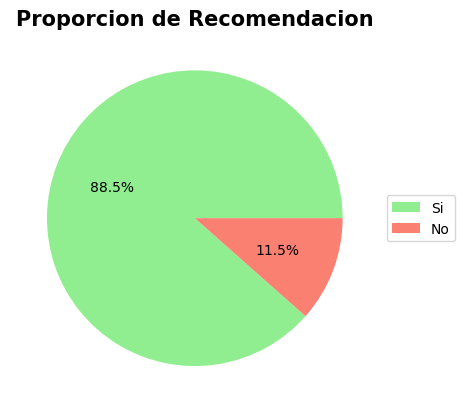

In [121]:
plt.pie(reviews['recommend'].value_counts(),autopct='%1.1f%%',colors=['lightgreen','salmon'])
plt.title('Proporcion de Recomendacion',fontsize=15,fontweight='bold')
plt.legend(['Si','No'],loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Sentiment_analysis

In [122]:
reviews['sentiment_analysis'].value_counts()

sentiment_analysis
1    45923
2    10121
0     2387
Name: count, dtype: int64

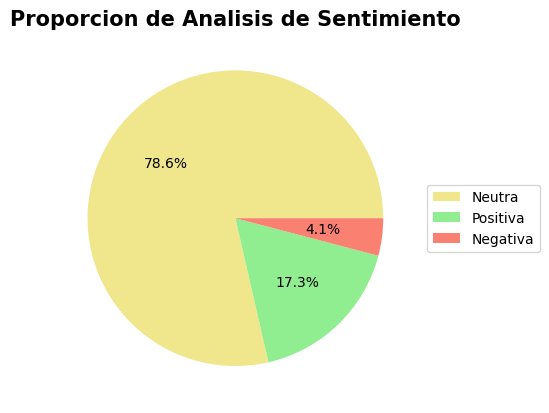

In [123]:
plt.pie(reviews['sentiment_analysis'].value_counts(),autopct='%1.1f%%',colors=['khaki','lightgreen','salmon'])
plt.title('Proporcion de Analisis de Sentimiento',fontsize=15,fontweight='bold')
plt.legend(['Neutra','Positiva','Negativa'],loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### User_id

In [124]:
reviews['user_id'].value_counts()

user_id
yoshi278              10
76561198101552611     10
TheUnderdog2020       10
nabady                10
SKELETRONPRIMEISOP    10
                      ..
Tattzie                1
sexyawp                1
GodLoveGuru            1
943525                 1
76561198277602337      1
Name: count, Length: 25458, dtype: int64

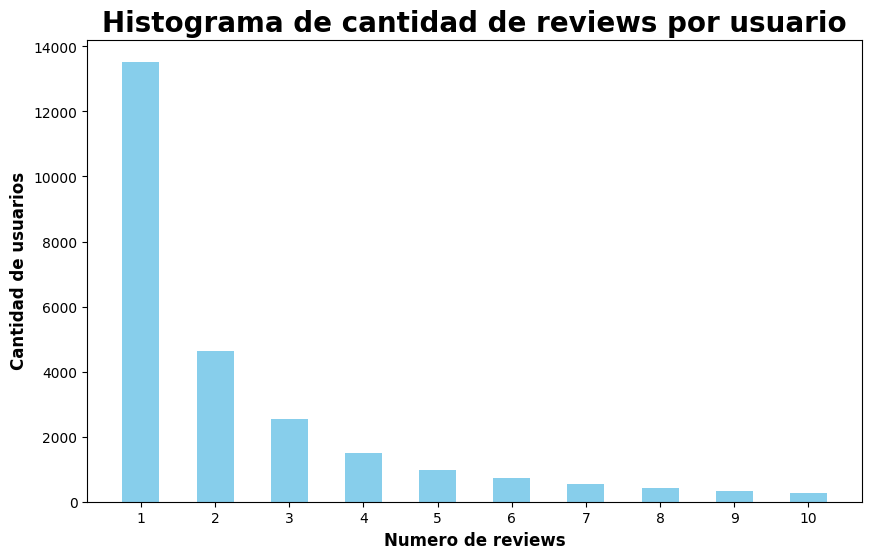

In [125]:
values_counts = reviews['user_id'].value_counts().value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(values_counts.index, values_counts.values, width=0.5, align='center',color='skyblue')
plt.title("Histograma de cantidad de reviews por usuario", fontweight='bold', fontsize=20)
plt.xlabel("Numero de reviews", fontweight='bold', fontsize=12)
plt.ylabel("Cantidad de usuarios", fontweight='bold', fontsize=12)
plt.xticks(ticks=values_counts.index)
plt.show()


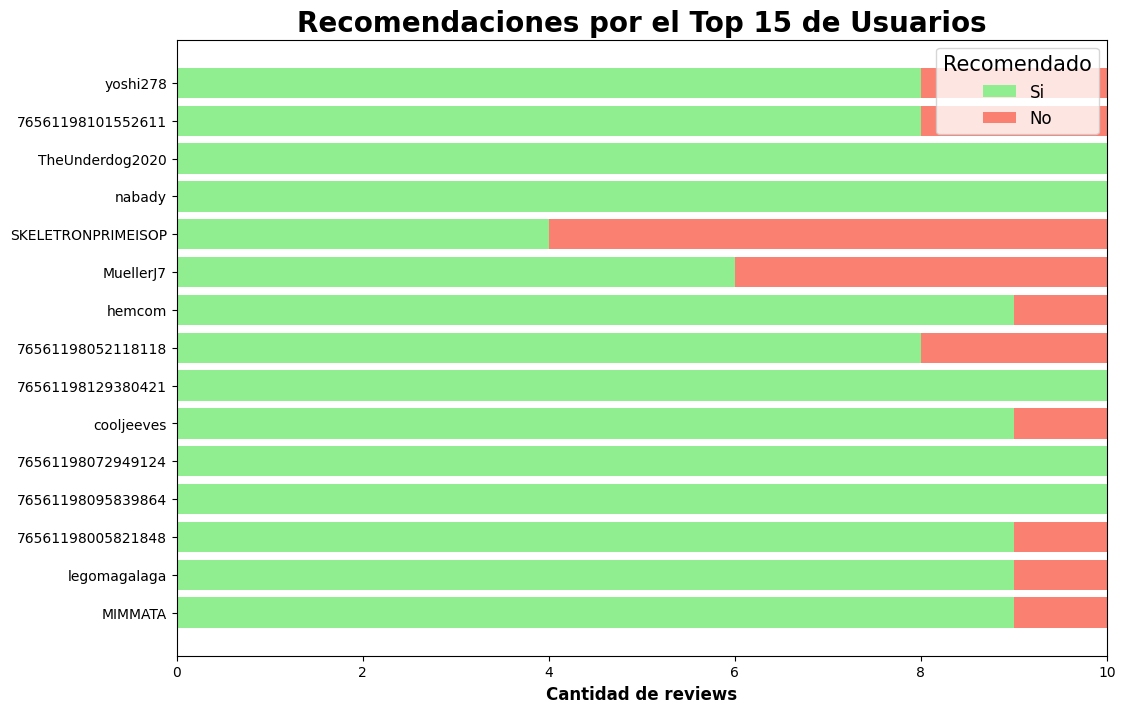

In [126]:
juegos = reviews['user_id'].dropna().value_counts().head(15).index
pos = reviews[reviews['recommend'] == True]['user_id'].value_counts().reindex(juegos, fill_value=0).values
neg = reviews[reviews['recommend'] == False]['user_id'].value_counts().reindex(juegos, fill_value=0).values

plt.figure(figsize=(12, 8))
plt.barh(juegos, pos, label='Si',color='lightgreen')
plt.barh(juegos, neg, left=pos, label='No', color='salmon')
plt.xlabel("Cantidad de reviews",fontweight='bold',fontsize=12)
plt.title("Recomendaciones por el Top 15 de Usuarios", fontweight='bold', fontsize=20)
plt.gca().invert_yaxis()
plt.legend(title='Recomendado',title_fontsize=15,fontsize=12)
plt.show()

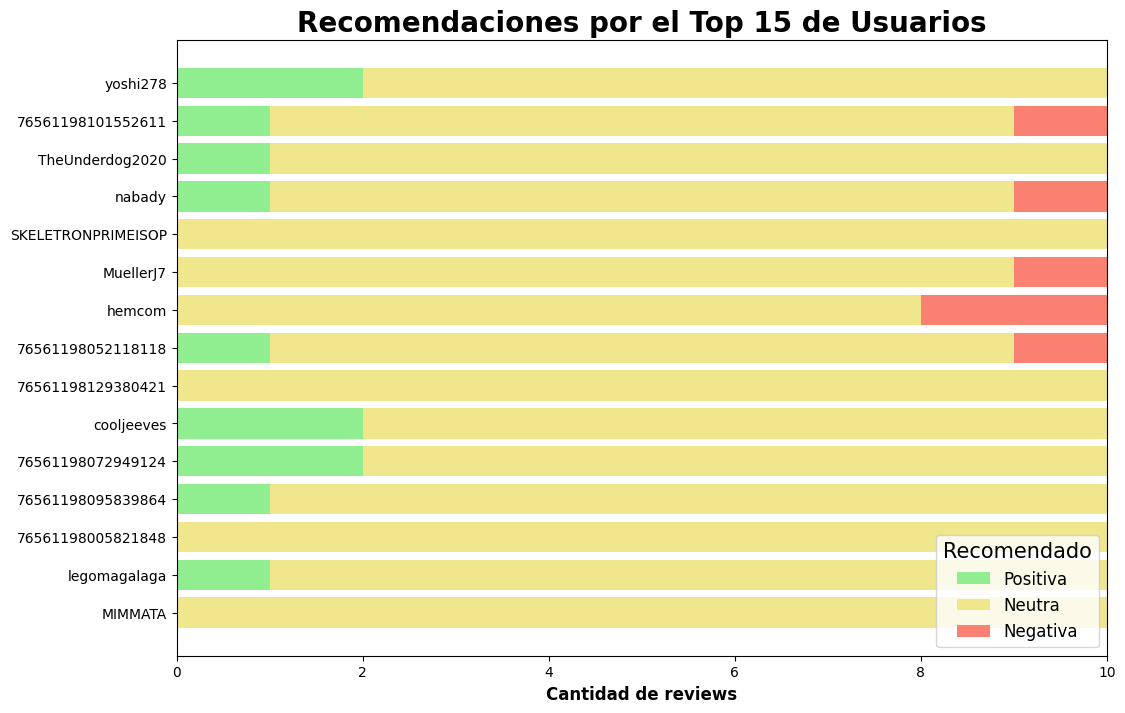

In [127]:
juegos = reviews['user_id'].dropna().value_counts().head(15).index
pos = reviews[reviews['sentiment_analysis'] == 2]['user_id'].value_counts().reindex(juegos, fill_value=0).values
neu = reviews[reviews['sentiment_analysis'] == 1]['user_id'].value_counts().reindex(juegos, fill_value=0).values
neg = reviews[reviews['sentiment_analysis'] == 0]['user_id'].value_counts().reindex(juegos, fill_value=0).values

plt.figure(figsize=(12, 8))
plt.barh(juegos, pos, label='Positiva',color='lightgreen')
plt.barh(juegos, neu, left=pos, label='Neutra', color='khaki')
plt.barh(juegos, neg, left=pos+neu, label='Negativa', color='salmon')
plt.xlabel("Cantidad de reviews",fontweight='bold',fontsize=12)
plt.title("Recomendaciones por el Top 15 de Usuarios", fontweight='bold', fontsize=20)
plt.gca().invert_yaxis()
plt.legend(title='Recomendado',title_fontsize=15,fontsize=12)
plt.show()

### Item_id y Item_name

Se tienen 204 registros con 'item_id', pero no 'item_name'. Por lo tanto, se decidio realizar el analisis solamente sobre la columna 'item_name'

In [128]:
reviews['item_id'].value_counts()

item_id
730.0       3708
440.0       3694
4000.0      1704
570.0       1544
218620.0    1113
            ... 
203250.0       1
385890.0       1
431840.0       1
256500.0       1
370360.0       1
Name: count, Length: 3682, dtype: int64

In [129]:
reviews['item_name'].value_counts()

item_name
Counter-Strike: Global Offensive              3708
Garry's Mod                                   1704
PAYDAY 2                                      1113
Unturned                                      1031
Rust                                           806
                                              ... 
Dungeon Party                                    1
Castle In The Darkness                           1
BIT.TRIP FATE                                    1
Action Henk                                      1
RollerCoaster Tycoon 2: Triple Thrill Pack       1
Name: count, Length: 3319, dtype: int64

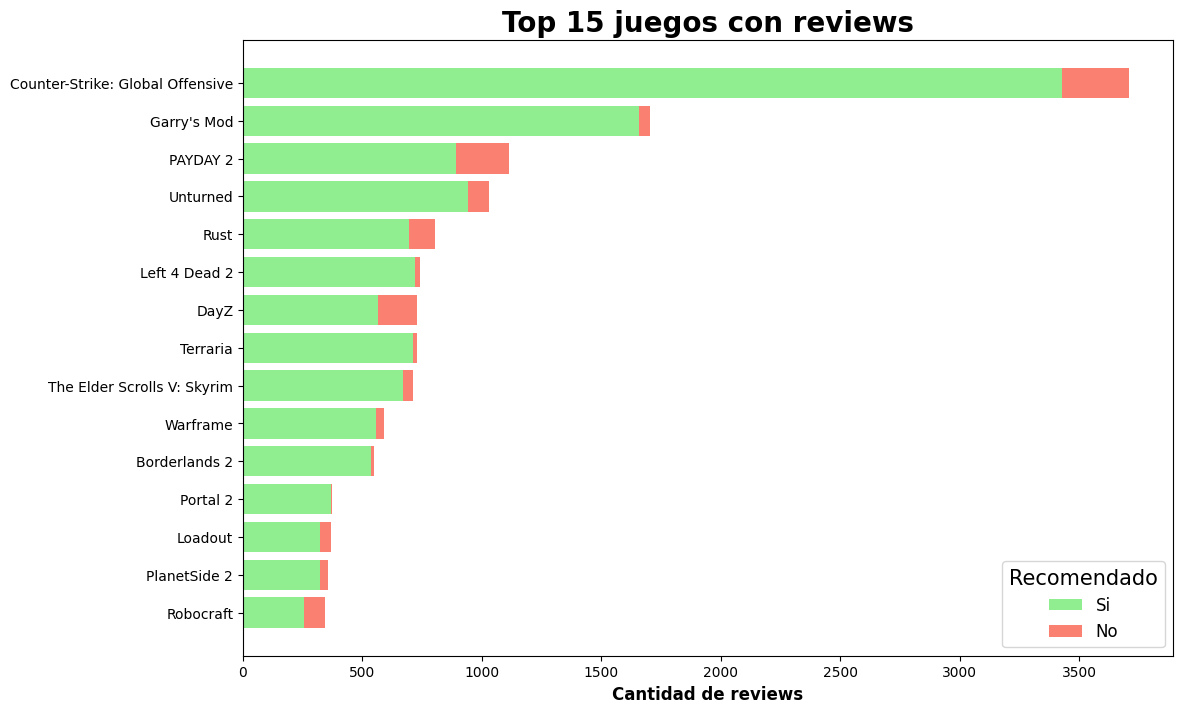

In [130]:
juegos = reviews['item_name'].dropna().value_counts().head(15).index
pos = reviews[reviews['recommend'] == True]['item_name'].value_counts().reindex(juegos, fill_value=0).values
neg = reviews[reviews['recommend'] == False]['item_name'].value_counts().reindex(juegos, fill_value=0).values

plt.figure(figsize=(12, 8))
plt.barh(juegos, pos, label='Si',color='lightgreen')
plt.barh(juegos, neg, left=pos, label='No', color='salmon')
plt.xlabel("Cantidad de reviews",fontweight='bold',fontsize=12)
plt.title("Top 15 juegos con reviews", fontweight='bold', fontsize=20)
plt.gca().invert_yaxis()
plt.legend(title='Recomendado',title_fontsize=15,fontsize=12)
plt.show()

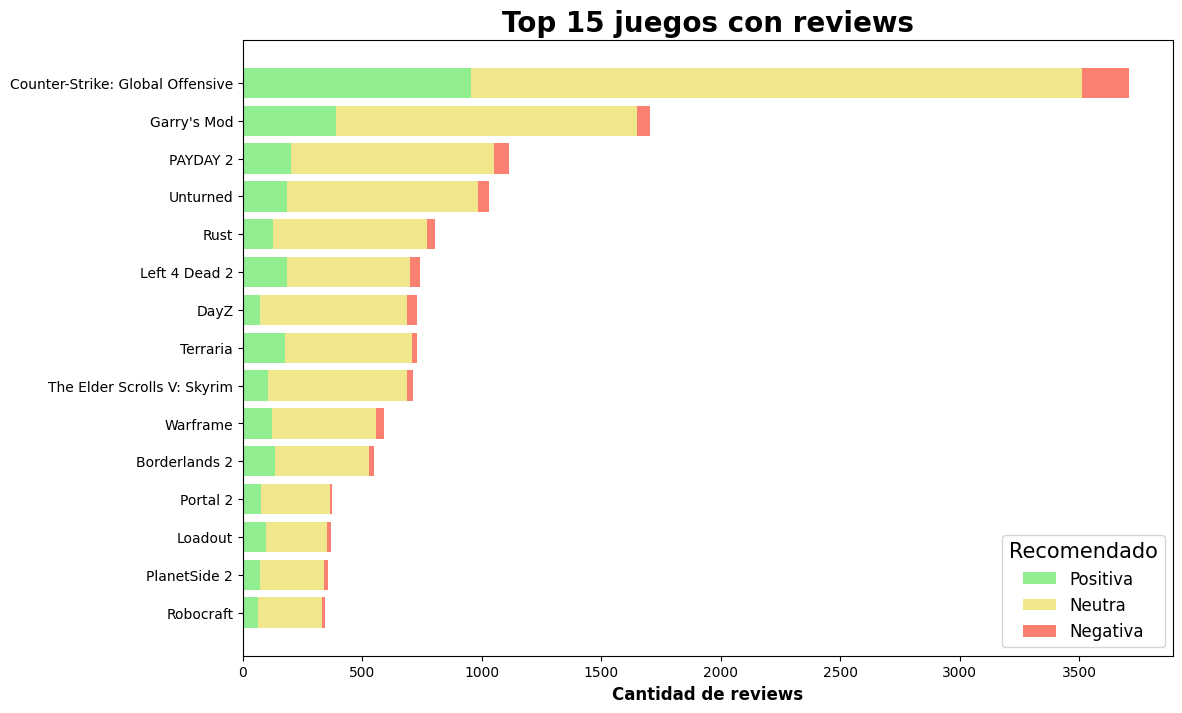

In [131]:
juegos = reviews['item_name'].dropna().value_counts().head(15).index
pos = reviews[reviews['sentiment_analysis'] == 2]['item_name'].value_counts().reindex(juegos, fill_value=0).values
neu = reviews[reviews['sentiment_analysis'] == 1]['item_name'].value_counts().reindex(juegos, fill_value=0).values
neg = reviews[reviews['sentiment_analysis'] == 0]['item_name'].value_counts().reindex(juegos, fill_value=0).values

plt.figure(figsize=(12, 8))
plt.barh(juegos, pos, label='Positiva',color='lightgreen')
plt.barh(juegos, neu, left=pos, label='Neutra', color='khaki')
plt.barh(juegos, neg, left=pos+neu, label='Negativa', color='salmon')
plt.xlabel("Cantidad de reviews",fontweight='bold',fontsize=12)
plt.title("Top 15 juegos con reviews", fontweight='bold', fontsize=20)
plt.gca().invert_yaxis()
plt.legend(title='Recomendado',title_fontsize=15,fontsize=12)
plt.show()

### Words

In [132]:
palabras = frec_unicos(reviews['words'])

In [133]:
palabras.head(15)

game      60261
not       10770
like      10617
good      10555
play      10346
fun       10257
get        9557
great      8967
one        7461
would      6909
really     6668
games      6259
best       5837
time       5516
even       4483
Name: count, dtype: int64

In [134]:
len(palabras)

67684

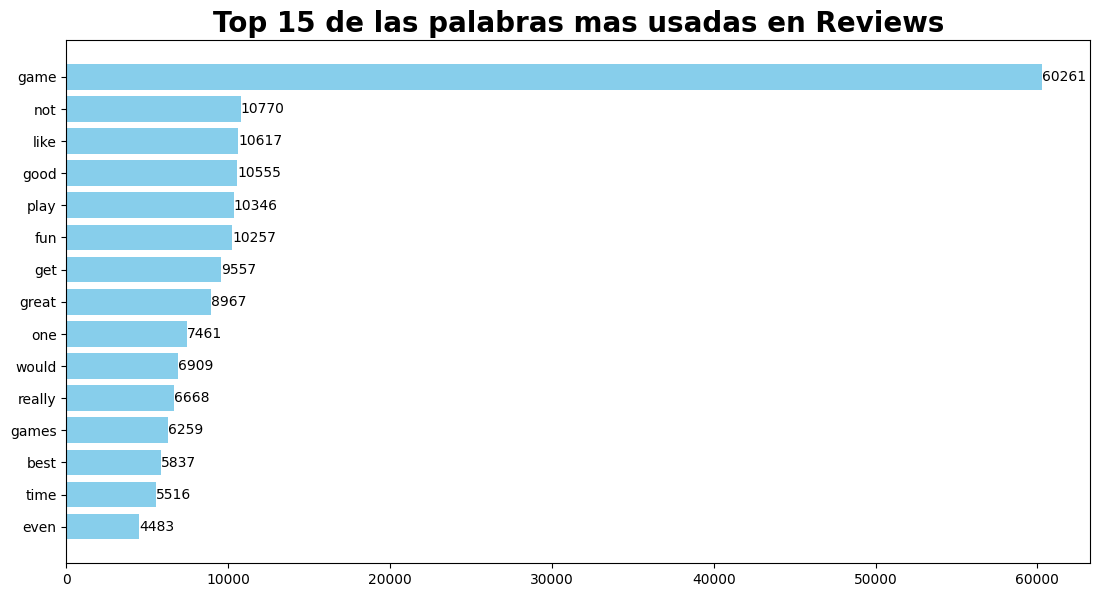

In [135]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(palabras.head(15).index,palabras.head(15).values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 de las palabras mas usadas en Reviews', fontweight = 'bold',fontsize=20)
for index, value in enumerate(palabras.head(15).values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Word_count

In [136]:
reviews['word_count'].describe()

count    58431.000000
mean        38.995533
std         82.006857
min          0.000000
25%          5.000000
50%         14.000000
75%         38.000000
max       2000.000000
Name: word_count, dtype: float64

In [137]:
reviews['word_count'].value_counts()

word_count
2       3516
3       2931
1       2734
4       2617
5       2243
        ... 
1100       1
967        1
803        1
1448       1
918        1
Name: count, Length: 741, dtype: int64

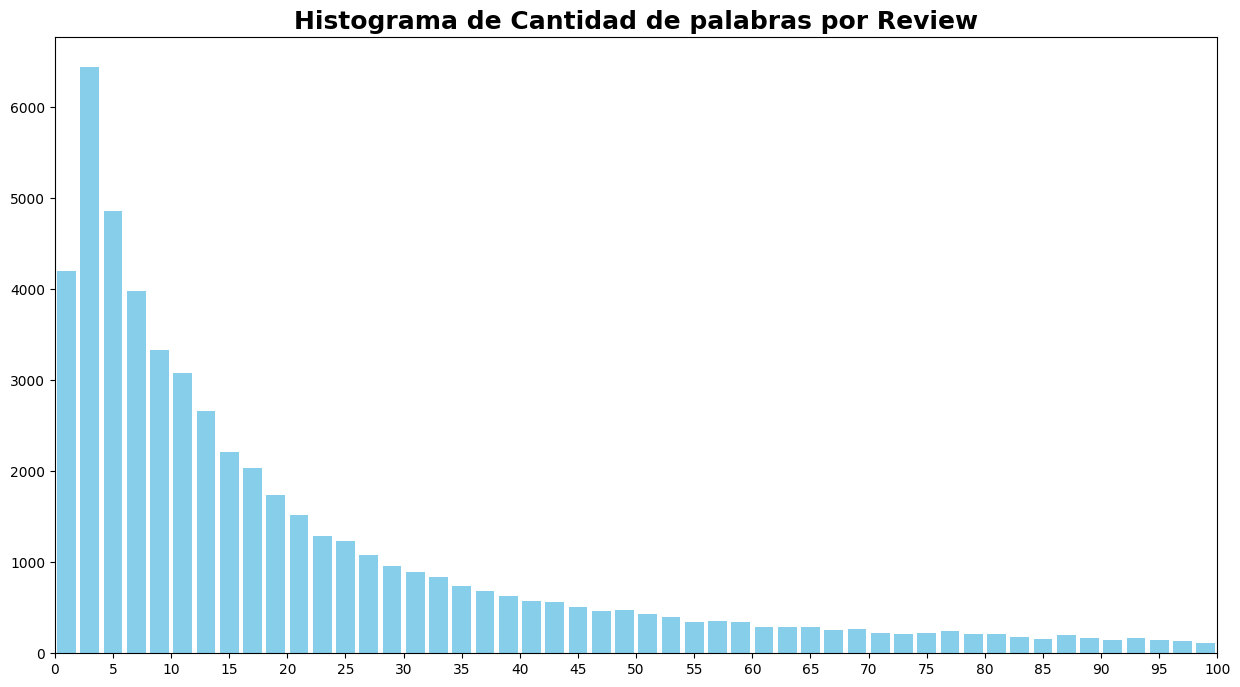

In [138]:
plt.figure(figsize=(15,8))
plt.hist(reviews['word_count'],bins=1000,color='skyblue',rwidth=0.8)
plt.title('Histograma de Cantidad de palabras por Review', fontweight = 'bold',fontsize=18)
plt.xlim(0,100)
plt.xticks(ticks=range(0,101,5))
plt.show()

### Analisis de Correlacion Reviews

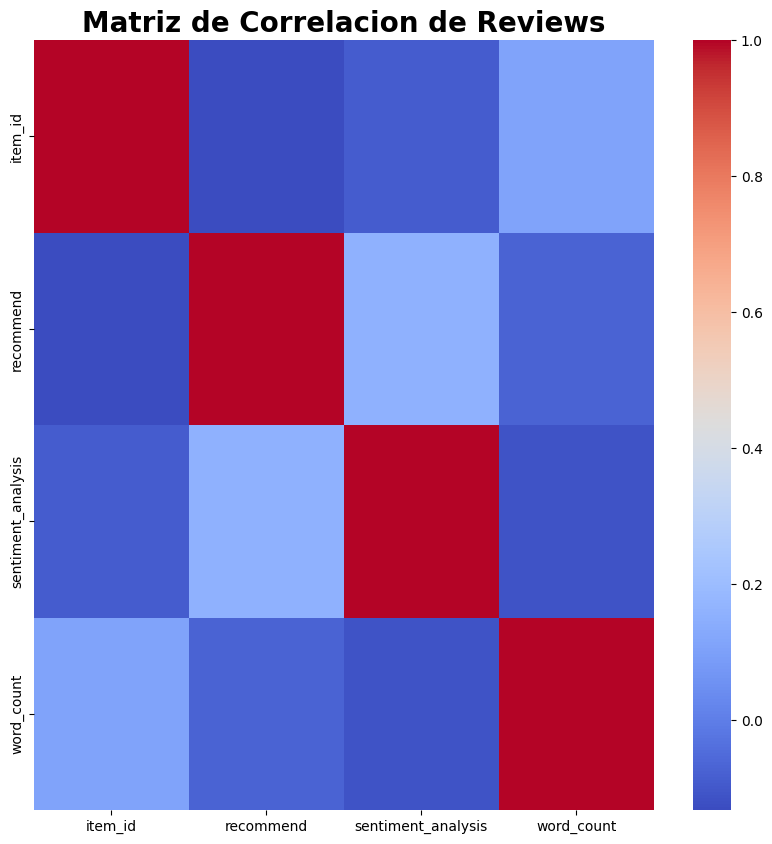

In [139]:
correlacion=reviews[['item_id','recommend','sentiment_analysis','word_count']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlacion,cmap='coolwarm')
plt.title('Matriz de Correlacion de Reviews', fontweight = 'bold',fontsize=20)
plt.show()

## Exportar archivos

In [140]:
pq.write_table(pa.Table.from_pandas(games),'Archivos EDA/games_eda.parquet')

In [141]:
pq.write_table(pa.Table.from_pandas(items),'Archivos EDA/items_eda.parquet')

In [142]:
pq.write_table(pa.Table.from_pandas(reviews),'Archivos EDA/reviews_eda.parquet')